# Forecasting Dish Subscribers Using Gated Recurrent Units (GRUs) - Part 1

In the code below, we develop our underlying models using the methodology defined in the README.

## Setup

* Import packages
* Set parameters
* Define file paths
* Load data from Excel

In [1]:
# Import packages
import numpy as np
import pandas as pd
from sklearn import preprocessing
from keras.layers import Input, GRU, Dense, concatenate, Activation
from keras.models import Model
import datetime
import sys
import random
import matplotlib as mpl
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Set parameters
trainingsize = 80 # Percent of data to use in training set
validation_size = 0 # Validation size for use in Keras' .fit
shuffle = False # shuffles inputs when fitting model
GRUnodes = 64
path = "C:\\Users\\nthor\\Desktop\\Kaggle\\Python\\"
file = "Dish Data.xlsx" # Name of .xlsx file
sheet = "Data" # Name of .xlsx sheet
span = 8 # Time lag for endogeneous variables used in baseline model (in quarters)
horiz = 6 # Steps in the future to predict (in quarters)
yweight = .4 # Weight of RNN based on y only
xyweight = 1 - yweight # Weight of RNN based on x + y
n_epoch = 5000 # set number of epochs
time_increment = 91 # delta_t used to create next series of dat. we're using quarters in our example

In [3]:
# Set random seed
seed = 2017
np.random.seed(seed)

In [4]:
# Load data
loc = path + file

# Open spreadsheet
Excel = pd.ExcelFile(loc)
raw = Excel.parse('Data')

In [5]:
# View data
raw.head()

,#,Year / Quarter,Pay-TV Customers Acq. (in hundred thousands),Cum. Customers Acq.,Q1 Impact,Q2 Impact,Q3 Impact,Recession,Sub. Promotion Subsidies,Recreation services,US GDP,Product Releases
0,1,1996Q1,2,2,1,0,0,0,33591,189.8,0.0461,0
1,2,1996Q2,29,31,0,1,0,0,33591,193.6,0.0600,0
2,3,1996Q3,70,101,0,0,1,0,33591,198.4,0.0587,0
3,4,1996Q4,104,205,0,0,0,0,33591,200.6,0.0625,0
4,5,1997Q1,133,338,1,0,0,0,145061,204.2,0.0645,0


In [6]:
# Load variables (convert to float64 to pre-empt modeling issues)
lastrow = len(raw) # Adjust for Zero Index

t = raw.iloc[0:lastrow, 0].astype('float64') # Time-steps (1,2, etc.)
dates = raw.iloc[0:lastrow, 1] # Quarter dates (e.g., 1996Q1)
newcust = raw.iloc[0:lastrow, 2].astype('float64') # Number of new Pay-TV customers
cumcust = raw.iloc[0:lastrow, 3].astype('float64') # Cumulative number of Pay-TV customers
q1 = raw.iloc[0:lastrow, 4].astype('float64') # Indicator for Q1 (created to capture seasonality effects)
q2 = raw.iloc[0:lastrow, 5].astype('float64') # Indicator for Q1 (created to capture seasonality effects)
q3 = raw.iloc[0:lastrow, 6].astype('float64') # Indicator for Q1 (created to capture seasonality effects)
recession = raw.iloc[0:lastrow, 7].astype('float64') # Indicator for the 2008 recession
subsidies = raw.iloc[0:lastrow, 8].astype('float64') # Dish promotional subsidies ($)
rec_spend = raw.iloc[0:lastrow, 9].astype('float64') # US Census avg. recreational spend by household
GDP = raw.iloc[0:lastrow, 10].astype('float64') # US GDP (%)
newprod = raw.iloc[0:lastrow, 11].astype('float64') # Indicator for introduction of SlingTV (low cost "cut the cord" option that likely led to a spike in subscribers)

## Data Transformation & Model Preparation

* Log-transform variables
* Define x and y variables
* Normalize metrics
* Define lag variables using user-defined 'span' variable

In [7]:
# Log-transform large variables to minimize outlier effects
ln_rec_spend = np.log(rec_spend)
ln_subsidies = np.log(subsidies)

In [8]:
# Define x and y variables (named as '_1' to denote pre-normalized values)
x_1 = pd.concat([q1, q2, q3, recession, ln_rec_spend, ln_subsidies, newprod], axis = 1)
y_1 = newcust
y_cum = cumcust 

In [9]:
# View x variables
x_1.head()

,Q1 Impact,Q2 Impact,Q3 Impact,Recession,Recreation services,Sub. Promotion Subsidies,Product Releases
0,1.0,0.0,0.0,0.0,5.245971,10.422013,0.0
1,0.0,1.0,0.0,0.0,5.265794,10.422013,0.0
2,0.0,0.0,1.0,0.0,5.290285,10.422013,0.0
3,0.0,0.0,0.0,0.0,5.301313,10.422013,0.0
4,1.0,0.0,0.0,0.0,5.319100,11.884910,0.0


In [10]:
# Normalize metrics
scaler_x = preprocessing.MinMaxScaler(feature_range = (0,1)) # Create scaler
scaler_y = preprocessing.MinMaxScaler(feature_range = (0,1))

x = np.array(x_1).reshape((len(x_1), len(x_1.columns))) # Reshape to avoid deprecation warning
x = scaler_x.fit_transform(x) # Transform x elements

y = np.array(y_1).reshape((len(y_1), 1))
y = scaler_y.fit_transform(y)

In [11]:
# Assemble matrices containing samples of x-spans, y-spans, and y-horizons across the available timeline
nsample = len(y) - span - horiz # The number of samples equals the number of observations minus our number of time lag and prediction observations
x_list = [np.expand_dims(np.atleast_2d(x[i:span + i,:]), axis = 0) for i in range(nsample)] # Group observations by our span parameter (2 by default)
x_mat = np.concatenate(x_list, axis = 0) # Concatenate these lists into a single numpy array

# Define y lag period
ylag_list = [np.expand_dims(np.atleast_2d(y[i:span + i, :]), axis = 0) for i in range(nsample)]
ylag_mat = np.concatenate(ylag_list, axis = 0) # Essentially are adding another list level: row to span period (2 by default)

# Define target horizon
y_list = [np.atleast_2d(y[i + span:span + i + horiz, 0]) for i in range(nsample)] # Groups the elements in y by our horizon parameter (i.e., groups 4 together into one list entry)
y_mat = np.concatenate(y_list, axis = 0) # Concatenate all list entries

# Define prediction observations for our span period (default of two span periods)
ilast = nsample # We will later reset nsample to zero, so need to define a new variable
xlast_list = [np.expand_dims(np.atleast_2d(x[ilast:span + ilast,:]), axis = 0)]
xlast_mat = np.concatenate(xlast_list, axis = 0)

ylastlag_list = [np.expand_dims(np.atleast_2d(y[ilast : span + ilast, :]), axis = 0)]
ylastlag_mat = np.concatenate(ylastlag_list, axis = 0)

## Modeling
* Split into test and training
* Develop GRUs and merge layers
* Train the model and fit results
* Generate forecasts

### Split data into test and training

In [12]:
# Define training sets
end = y_mat.shape[0] - 1 # Set the end of our data
learning_end = (end * trainingsize)//100 # Marks end of training set

x_mat_train = x_mat[0:learning_end,] # Define x-variables in training set
y_mat_train = y_mat[0:learning_end,] # Define y-variable in training set
ylag_mat_train = ylag_mat[0:learning_end,] # Define lagging y-variables in training set

In [13]:
# Define test sets
x_mat_test = x_mat[learning_end + 1:end,] # Define x-variables in test set
y_mat_test = y_mat[learning_end + 1:end,] # Contains 15-time spans, with each t+1 from the preceeding span equaling t in the proceeding span 
ylag_mat_test = ylag_mat[learning_end + 1:end,]

In [14]:
# Observe shape of training set to spot-check; we expect the 61 observations from our training set to be grouped into groups of 2 (per span) with 7 elements per observation
x_mat_train.shape

(55, 8, 7)

### Develop GRUs

In [15]:
# Create baseline ("main") GRU network
main_in = Input(shape = (ylag_mat_train.shape[1], 1), dtype = 'float32', name = 'main_in') # Initialize input layer and define data shape
main_gru = GRU(return_sequences = False, activation = 'tanh', units = GRUnodes, recurrent_activation = 'hard_sigmoid')(main_in) # Creates GRU with pre-defined number of nodes using tanh activation function
main_out = Dense(horiz, activation = 'linear', name = 'main_out')(main_gru) # Implements the operation without any activation being applied (i.e., linear)

In [16]:
# Create separate GRU network for both exogenous and endogenous metrics
exo_in = Input(shape = (x_mat_train.shape[1], x_mat_train.shape[2]), dtype = 'float32', name = 'exo_in') # Shapes the input using the number of rows (2) and columns (7) in the array
exo_gru = GRU(return_sequences = False, activation = 'tanh', units = GRUnodes, recurrent_activation = 'hard_sigmoid')(exo_in)
exo_out = Dense(horiz, activation = 'linear', name = 'exo_out')(exo_gru)

In [17]:
# Merge the two GRU layers
merged_layers = concatenate([main_gru, exo_gru])

# Create a dense layer for all merged data elements
combo_out = Dense(horiz, activation = 'sigmoid', name = 'combo_out')(merged_layers)

In [18]:
# Define final model input / output flows; compile parameters
model = Model(inputs = [main_in, exo_in], outputs = [main_out, combo_out]) # Creates two lists of entries: our baseline and our combo
model.compile(optimizer = 'rmsprop', 
              loss = 'mean_squared_error', # Uses MSE as error term (rather than MAPE or alternatives) 
              loss_weights = [yweight, xyweight]) 

### Train and test the final model

In [19]:
# Train the final model
model.fit({'main_in' : ylag_mat_train, 
           'exo_in' : x_mat_train}, 
          {'main_out' : y_mat_train, 
           'combo_out':y_mat_train},
          epochs = n_epoch,
          shuffle = shuffle,
          validation_split = validation_size)

Epoch 1/5000
55/55 [==============================] - 1s - loss: 0.2232 - main_out_loss: 0.4412 - combo_out_loss: 0.0778     
Epoch 2/5000
55/55 [==============================] - 0s - loss: 0.1587 - main_out_loss: 0.3077 - combo_out_loss: 0.0594     
Epoch 3/5000
55/55 [==============================] - 0s - loss: 0.1130 - main_out_loss: 0.2130 - combo_out_loss: 0.0463     
Epoch 4/5000
55/55 [==============================] - 0s - loss: 0.0760 - main_out_loss: 0.1372 - combo_out_loss: 0.0352     
Epoch 5/5000
55/55 [==============================] - 0s - loss: 0.0489 - main_out_loss: 0.0826 - combo_out_loss: 0.0263     
Epoch 6/5000
55/55 [==============================] - 0s - loss: 0.0323 - main_out_loss: 0.0502 - combo_out_loss: 0.0204     
Epoch 7/5000
55/55 [==============================] - 0s - loss: 0.0238 - main_out_loss: 0.0338 - combo_out_loss: 0.0172     
Epoch 8/5000
55/55 [==============================] - 0s - loss: 0.0199 - main_out_loss: 0.0261 - combo_out_loss: 0.01

55/55 [==============================] - 0s - loss: 0.0095 - main_out_loss: 0.0126 - combo_out_loss: 0.0075     
Epoch 66/5000
55/55 [==============================] - 0s - loss: 0.0092 - main_out_loss: 0.0124 - combo_out_loss: 0.0071     
Epoch 67/5000
55/55 [==============================] - 0s - loss: 0.0093 - main_out_loss: 0.0121 - combo_out_loss: 0.0074     
Epoch 68/5000
55/55 [==============================] - 0s - loss: 0.0091 - main_out_loss: 0.0121 - combo_out_loss: 0.0071     
Epoch 69/5000
55/55 [==============================] - 0s - loss: 0.0091 - main_out_loss: 0.0122 - combo_out_loss: 0.0070     
Epoch 70/5000
55/55 [==============================] - 0s - loss: 0.0093 - main_out_loss: 0.0122 - combo_out_loss: 0.0074     
Epoch 71/5000
55/55 [==============================] - 0s - loss: 0.0090 - main_out_loss: 0.0120 - combo_out_loss: 0.0069     
Epoch 72/5000
55/55 [==============================] - 0s - loss: 0.0090 - main_out_loss: 0.0118 - combo_out_loss: 0.0071    

55/55 [==============================] - 0s - loss: 0.0074 - main_out_loss: 0.0101 - combo_out_loss: 0.0055     
Epoch 130/5000
55/55 [==============================] - 0s - loss: 0.0074 - main_out_loss: 0.0099 - combo_out_loss: 0.0058     
Epoch 131/5000
55/55 [==============================] - 0s - loss: 0.0073 - main_out_loss: 0.0099 - combo_out_loss: 0.0056     
Epoch 132/5000
55/55 [==============================] - 0s - loss: 0.0074 - main_out_loss: 0.0101 - combo_out_loss: 0.0056     
Epoch 133/5000
55/55 [==============================] - 0s - loss: 0.0074 - main_out_loss: 0.0101 - combo_out_loss: 0.0056     
Epoch 134/5000
55/55 [==============================] - 0s - loss: 0.0073 - main_out_loss: 0.0099 - combo_out_loss: 0.0055     
Epoch 135/5000
55/55 [==============================] - 0s - loss: 0.0073 - main_out_loss: 0.0098 - combo_out_loss: 0.0057     
Epoch 136/5000
55/55 [==============================] - 0s - loss: 0.0072 - main_out_loss: 0.0099 - combo_out_loss: 0.0

55/55 [==============================] - 0s - loss: 0.0065 - main_out_loss: 0.0093 - combo_out_loss: 0.0047     
Epoch 192/5000
55/55 [==============================] - 0s - loss: 0.0064 - main_out_loss: 0.0093 - combo_out_loss: 0.0045     
Epoch 193/5000
55/55 [==============================] - 0s - loss: 0.0065 - main_out_loss: 0.0095 - combo_out_loss: 0.0045     
Epoch 194/5000
55/55 [==============================] - 0s - loss: 0.0066 - main_out_loss: 0.0095 - combo_out_loss: 0.0046     
Epoch 195/5000
55/55 [==============================] - 0s - loss: 0.0064 - main_out_loss: 0.0094 - combo_out_loss: 0.0045     
Epoch 196/5000
55/55 [==============================] - 0s - loss: 0.0065 - main_out_loss: 0.0092 - combo_out_loss: 0.0047     
Epoch 197/5000
55/55 [==============================] - 0s - loss: 0.0064 - main_out_loss: 0.0093 - combo_out_loss: 0.0044     
Epoch 198/5000
55/55 [==============================] - 0s - loss: 0.0066 - main_out_loss: 0.0095 - combo_out_loss: 0.0

55/55 [==============================] - 0s - loss: 0.0058 - main_out_loss: 0.0091 - combo_out_loss: 0.0037     
Epoch 256/5000
55/55 [==============================] - 0s - loss: 0.0058 - main_out_loss: 0.0089 - combo_out_loss: 0.0038     
Epoch 257/5000
55/55 [==============================] - 0s - loss: 0.0057 - main_out_loss: 0.0089 - combo_out_loss: 0.0036     
Epoch 258/5000
55/55 [==============================] - 0s - loss: 0.0058 - main_out_loss: 0.0090 - combo_out_loss: 0.0036     
Epoch 259/5000
55/55 [==============================] - 0s - loss: 0.0060 - main_out_loss: 0.0091 - combo_out_loss: 0.0039     
Epoch 260/5000
55/55 [==============================] - 0s - loss: 0.0058 - main_out_loss: 0.0090 - combo_out_loss: 0.0037     
Epoch 261/5000
55/55 [==============================] - 0s - loss: 0.0057 - main_out_loss: 0.0088 - combo_out_loss: 0.0037     
Epoch 262/5000
55/55 [==============================] - 0s - loss: 0.0058 - main_out_loss: 0.0090 - combo_out_loss: 0.0

55/55 [==============================] - 0s - loss: 0.0052 - main_out_loss: 0.0086 - combo_out_loss: 0.0030     
Epoch 320/5000
55/55 [==============================] - 0s - loss: 0.0054 - main_out_loss: 0.0087 - combo_out_loss: 0.0032     
Epoch 321/5000
55/55 [==============================] - 0s - loss: 0.0055 - main_out_loss: 0.0088 - combo_out_loss: 0.0033     
Epoch 322/5000
55/55 [==============================] - 0s - loss: 0.0053 - main_out_loss: 0.0085 - combo_out_loss: 0.0031     
Epoch 323/5000
55/55 [==============================] - 0s - loss: 0.0053 - main_out_loss: 0.0088 - combo_out_loss: 0.0030     
Epoch 324/5000
55/55 [==============================] - 0s - loss: 0.0051 - main_out_loss: 0.0085 - combo_out_loss: 0.0028     
Epoch 325/5000
55/55 [==============================] - 0s - loss: 0.0051 - main_out_loss: 0.0086 - combo_out_loss: 0.0028     
Epoch 326/5000
55/55 [==============================] - 0s - loss: 0.0051 - main_out_loss: 0.0086 - combo_out_loss: 0.0

55/55 [==============================] - 0s - loss: 0.0049 - main_out_loss: 0.0085 - combo_out_loss: 0.0024     
Epoch 384/5000
55/55 [==============================] - 0s - loss: 0.0047 - main_out_loss: 0.0083 - combo_out_loss: 0.0023     
Epoch 385/5000
55/55 [==============================] - 0s - loss: 0.0048 - main_out_loss: 0.0083 - combo_out_loss: 0.0024     
Epoch 386/5000
55/55 [==============================] - 0s - loss: 0.0047 - main_out_loss: 0.0083 - combo_out_loss: 0.0023     
Epoch 387/5000
55/55 [==============================] - 0s - loss: 0.0047 - main_out_loss: 0.0083 - combo_out_loss: 0.0023     
Epoch 388/5000
55/55 [==============================] - 0s - loss: 0.0047 - main_out_loss: 0.0084 - combo_out_loss: 0.0023     
Epoch 389/5000
55/55 [==============================] - 0s - loss: 0.0047 - main_out_loss: 0.0084 - combo_out_loss: 0.0023     
Epoch 390/5000
55/55 [==============================] - 0s - loss: 0.0047 - main_out_loss: 0.0083 - combo_out_loss: 0.0

55/55 [==============================] - 0s - loss: 0.0043 - main_out_loss: 0.0080 - combo_out_loss: 0.0019     
Epoch 447/5000
55/55 [==============================] - 0s - loss: 0.0044 - main_out_loss: 0.0081 - combo_out_loss: 0.0019     
Epoch 448/5000
55/55 [==============================] - 0s - loss: 0.0044 - main_out_loss: 0.0081 - combo_out_loss: 0.0019     
Epoch 449/5000
55/55 [==============================] - 0s - loss: 0.0044 - main_out_loss: 0.0081 - combo_out_loss: 0.0019     
Epoch 450/5000
55/55 [==============================] - 0s - loss: 0.0044 - main_out_loss: 0.0081 - combo_out_loss: 0.0019     
Epoch 451/5000
55/55 [==============================] - 0s - loss: 0.0044 - main_out_loss: 0.0082 - combo_out_loss: 0.0019     
Epoch 452/5000
55/55 [==============================] - 0s - loss: 0.0044 - main_out_loss: 0.0081 - combo_out_loss: 0.0019     
Epoch 453/5000
55/55 [==============================] - 0s - loss: 0.0044 - main_out_loss: 0.0082 - combo_out_loss: 0.0

55/55 [==============================] - 0s - loss: 0.0042 - main_out_loss: 0.0080 - combo_out_loss: 0.0016     
Epoch 511/5000
55/55 [==============================] - 0s - loss: 0.0041 - main_out_loss: 0.0080 - combo_out_loss: 0.0016     
Epoch 512/5000
55/55 [==============================] - 0s - loss: 0.0041 - main_out_loss: 0.0079 - combo_out_loss: 0.0016     
Epoch 513/5000
55/55 [==============================] - 0s - loss: 0.0041 - main_out_loss: 0.0079 - combo_out_loss: 0.0016     
Epoch 514/5000
55/55 [==============================] - 0s - loss: 0.0041 - main_out_loss: 0.0079 - combo_out_loss: 0.0016     
Epoch 515/5000
55/55 [==============================] - 0s - loss: 0.0041 - main_out_loss: 0.0079 - combo_out_loss: 0.0016     
Epoch 516/5000
55/55 [==============================] - 0s - loss: 0.0040 - main_out_loss: 0.0078 - combo_out_loss: 0.0015     
Epoch 517/5000
55/55 [==============================] - 0s - loss: 0.0041 - main_out_loss: 0.0078 - combo_out_loss: 0.0

55/55 [==============================] - 0s - loss: 0.0040 - main_out_loss: 0.0079 - combo_out_loss: 0.0014     
Epoch 575/5000
55/55 [==============================] - 0s - loss: 0.0039 - main_out_loss: 0.0076 - combo_out_loss: 0.0015     
Epoch 576/5000
55/55 [==============================] - 0s - loss: 0.0039 - main_out_loss: 0.0077 - combo_out_loss: 0.0014     
Epoch 577/5000
55/55 [==============================] - 0s - loss: 0.0038 - main_out_loss: 0.0076 - combo_out_loss: 0.0013     
Epoch 578/5000
55/55 [==============================] - 0s - loss: 0.0038 - main_out_loss: 0.0077 - combo_out_loss: 0.0013     
Epoch 579/5000
55/55 [==============================] - 0s - loss: 0.0038 - main_out_loss: 0.0076 - combo_out_loss: 0.0012     
Epoch 580/5000
55/55 [==============================] - 0s - loss: 0.0038 - main_out_loss: 0.0076 - combo_out_loss: 0.0012     
Epoch 581/5000
55/55 [==============================] - 0s - loss: 0.0038 - main_out_loss: 0.0076 - combo_out_loss: 0.0

55/55 [==============================] - 0s - loss: 0.0037 - main_out_loss: 0.0075 - combo_out_loss: 0.0012     
Epoch 639/5000
55/55 [==============================] - 0s - loss: 0.0037 - main_out_loss: 0.0075 - combo_out_loss: 0.0012     
Epoch 640/5000
55/55 [==============================] - 0s - loss: 0.0037 - main_out_loss: 0.0074 - combo_out_loss: 0.0012     
Epoch 641/5000
55/55 [==============================] - 0s - loss: 0.0037 - main_out_loss: 0.0073 - combo_out_loss: 0.0012     
Epoch 642/5000
55/55 [==============================] - 0s - loss: 0.0037 - main_out_loss: 0.0074 - combo_out_loss: 0.0012     
Epoch 643/5000
55/55 [==============================] - 0s - loss: 0.0037 - main_out_loss: 0.0073 - combo_out_loss: 0.0012     
Epoch 644/5000
55/55 [==============================] - 0s - loss: 0.0037 - main_out_loss: 0.0075 - combo_out_loss: 0.0012     
Epoch 645/5000
55/55 [==============================] - 0s - loss: 0.0037 - main_out_loss: 0.0073 - combo_out_loss: 0.0

55/55 [==============================] - 0s - loss: 0.0035 - main_out_loss: 0.0072 - combo_out_loss: 0.0011     
Epoch 702/5000
55/55 [==============================] - 0s - loss: 0.0035 - main_out_loss: 0.0072 - combo_out_loss: 0.0011     
Epoch 703/5000
55/55 [==============================] - 0s - loss: 0.0035 - main_out_loss: 0.0071 - combo_out_loss: 0.0011     
Epoch 704/5000
55/55 [==============================] - 0s - loss: 0.0035 - main_out_loss: 0.0072 - combo_out_loss: 0.0011     
Epoch 705/5000
55/55 [==============================] - 0s - loss: 0.0035 - main_out_loss: 0.0071 - combo_out_loss: 0.0011     
Epoch 706/5000
55/55 [==============================] - 0s - loss: 0.0036 - main_out_loss: 0.0073 - combo_out_loss: 0.0012     
Epoch 707/5000
55/55 [==============================] - 0s - loss: 0.0035 - main_out_loss: 0.0071 - combo_out_loss: 0.0012     
Epoch 708/5000
55/55 [==============================] - 0s - loss: 0.0036 - main_out_loss: 0.0072 - combo_out_loss: 0.0

55/55 [==============================] - 0s - loss: 0.0034 - main_out_loss: 0.0069 - combo_out_loss: 9.6417e-04 
Epoch 766/5000
55/55 [==============================] - 0s - loss: 0.0034 - main_out_loss: 0.0071 - combo_out_loss: 9.8938e-04 
Epoch 767/5000
55/55 [==============================] - 0s - loss: 0.0034 - main_out_loss: 0.0070 - combo_out_loss: 0.0010     
Epoch 768/5000
55/55 [==============================] - 0s - loss: 0.0035 - main_out_loss: 0.0071 - combo_out_loss: 0.0011     
Epoch 769/5000
55/55 [==============================] - 0s - loss: 0.0035 - main_out_loss: 0.0070 - combo_out_loss: 0.0011     
Epoch 770/5000
55/55 [==============================] - 0s - loss: 0.0035 - main_out_loss: 0.0072 - combo_out_loss: 0.0011     
Epoch 771/5000
55/55 [==============================] - 0s - loss: 0.0034 - main_out_loss: 0.0071 - combo_out_loss: 0.0010     
Epoch 772/5000
55/55 [==============================] - 0s - loss: 0.0034 - main_out_loss: 0.0071 - combo_out_loss: 9.6

55/55 [==============================] - 0s - loss: 0.0035 - main_out_loss: 0.0071 - combo_out_loss: 0.0010     
Epoch 829/5000
55/55 [==============================] - 0s - loss: 0.0034 - main_out_loss: 0.0070 - combo_out_loss: 0.0010     
Epoch 830/5000
55/55 [==============================] - 0s - loss: 0.0034 - main_out_loss: 0.0070 - combo_out_loss: 9.6514e-04 
Epoch 831/5000
55/55 [==============================] - 0s - loss: 0.0033 - main_out_loss: 0.0069 - combo_out_loss: 9.5860e-04 
Epoch 832/5000
55/55 [==============================] - 0s - loss: 0.0033 - main_out_loss: 0.0069 - combo_out_loss: 9.1298e-04 
Epoch 833/5000
55/55 [==============================] - 0s - loss: 0.0033 - main_out_loss: 0.0069 - combo_out_loss: 9.0599e-04 
Epoch 834/5000
55/55 [==============================] - 0s - loss: 0.0034 - main_out_loss: 0.0071 - combo_out_loss: 9.1580e-04 
Epoch 835/5000
55/55 [==============================] - 0s - loss: 0.0033 - main_out_loss: 0.0069 - combo_out_loss: 9.4

55/55 [==============================] - 0s - loss: 0.0034 - main_out_loss: 0.0069 - combo_out_loss: 9.5468e-04 
Epoch 893/5000
55/55 [==============================] - 0s - loss: 0.0033 - main_out_loss: 0.0068 - combo_out_loss: 0.0010     
Epoch 894/5000
55/55 [==============================] - 0s - loss: 0.0033 - main_out_loss: 0.0068 - combo_out_loss: 9.2922e-04 
Epoch 895/5000
55/55 [==============================] - 0s - loss: 0.0032 - main_out_loss: 0.0068 - combo_out_loss: 8.9855e-04 
Epoch 896/5000
55/55 [==============================] - 0s - loss: 0.0033 - main_out_loss: 0.0069 - combo_out_loss: 8.5697e-04 
Epoch 897/5000
55/55 [==============================] - 0s - loss: 0.0032 - main_out_loss: 0.0069 - combo_out_loss: 8.2913e-04 
Epoch 898/5000
55/55 [==============================] - 0s - loss: 0.0033 - main_out_loss: 0.0070 - combo_out_loss: 8.4022e-04 
Epoch 899/5000
55/55 [==============================] - 0s - loss: 0.0033 - main_out_loss: 0.0069 - combo_out_loss: 8.7

55/55 [==============================] - 0s - loss: 0.0032 - main_out_loss: 0.0067 - combo_out_loss: 9.0256e-04 
Epoch 956/5000
55/55 [==============================] - 0s - loss: 0.0032 - main_out_loss: 0.0068 - combo_out_loss: 8.4044e-04 
Epoch 957/5000
55/55 [==============================] - 0s - loss: 0.0032 - main_out_loss: 0.0068 - combo_out_loss: 8.2091e-04 
Epoch 958/5000
55/55 [==============================] - 0s - loss: 0.0033 - main_out_loss: 0.0070 - combo_out_loss: 8.4505e-04 
Epoch 959/5000
55/55 [==============================] - 0s - loss: 0.0033 - main_out_loss: 0.0068 - combo_out_loss: 9.0200e-04 
Epoch 960/5000
55/55 [==============================] - 0s - loss: 0.0032 - main_out_loss: 0.0068 - combo_out_loss: 8.6386e-04 
Epoch 961/5000
55/55 [==============================] - 0s - loss: 0.0032 - main_out_loss: 0.0067 - combo_out_loss: 8.7383e-04 
Epoch 962/5000
55/55 [==============================] - 0s - loss: 0.0032 - main_out_loss: 0.0067 - combo_out_loss: 8.3

55/55 [==============================] - 0s - loss: 0.0031 - main_out_loss: 0.0068 - combo_out_loss: 7.3227e-04 
Epoch 1018/5000
55/55 [==============================] - 0s - loss: 0.0031 - main_out_loss: 0.0067 - combo_out_loss: 7.4164e-04 
Epoch 1019/5000
55/55 [==============================] - 0s - loss: 0.0031 - main_out_loss: 0.0067 - combo_out_loss: 8.0497e-04 
Epoch 1020/5000
55/55 [==============================] - 0s - loss: 0.0032 - main_out_loss: 0.0068 - combo_out_loss: 8.4355e-04 
Epoch 1021/5000
55/55 [==============================] - 0s - loss: 0.0032 - main_out_loss: 0.0066 - combo_out_loss: 9.0301e-04 
Epoch 1022/5000
55/55 [==============================] - 0s - loss: 0.0033 - main_out_loss: 0.0067 - combo_out_loss: 9.3983e-04 
Epoch 1023/5000
55/55 [==============================] - 0s - loss: 0.0032 - main_out_loss: 0.0067 - combo_out_loss: 9.3626e-04 
Epoch 1024/5000
55/55 [==============================] - 0s - loss: 0.0032 - main_out_loss: 0.0067 - combo_out_lo

55/55 [==============================] - 0s - loss: 0.0031 - main_out_loss: 0.0067 - combo_out_loss: 6.7984e-04 
Epoch 1081/5000
55/55 [==============================] - 0s - loss: 0.0031 - main_out_loss: 0.0066 - combo_out_loss: 7.0359e-04 
Epoch 1082/5000
55/55 [==============================] - 0s - loss: 0.0031 - main_out_loss: 0.0066 - combo_out_loss: 7.0467e-04 
Epoch 1083/5000
55/55 [==============================] - 0s - loss: 0.0031 - main_out_loss: 0.0065 - combo_out_loss: 7.5919e-04 
Epoch 1084/5000
55/55 [==============================] - 0s - loss: 0.0033 - main_out_loss: 0.0069 - combo_out_loss: 8.5339e-04 
Epoch 1085/5000
55/55 [==============================] - 0s - loss: 0.0032 - main_out_loss: 0.0066 - combo_out_loss: 0.0010     
Epoch 1086/5000
55/55 [==============================] - 0s - loss: 0.0032 - main_out_loss: 0.0067 - combo_out_loss: 9.4530e-04 
Epoch 1087/5000
55/55 [==============================] - ETA: 0s - loss: 0.0029 - main_out_loss: 0.0053 - combo_o

55/55 [==============================] - 0s - loss: 0.0030 - main_out_loss: 0.0065 - combo_out_loss: 6.5371e-04 
Epoch 1144/5000
55/55 [==============================] - 0s - loss: 0.0030 - main_out_loss: 0.0066 - combo_out_loss: 6.4202e-04 
Epoch 1145/5000
55/55 [==============================] - 0s - loss: 0.0031 - main_out_loss: 0.0067 - combo_out_loss: 6.7088e-04 
Epoch 1146/5000
55/55 [==============================] - 0s - loss: 0.0032 - main_out_loss: 0.0069 - combo_out_loss: 7.3545e-04 
Epoch 1147/5000
55/55 [==============================] - 0s - loss: 0.0032 - main_out_loss: 0.0064 - combo_out_loss: 9.6340e-04 
Epoch 1148/5000
55/55 [==============================] - 0s - loss: 0.0032 - main_out_loss: 0.0065 - combo_out_loss: 9.4798e-04 
Epoch 1149/5000
55/55 [==============================] - 0s - loss: 0.0031 - main_out_loss: 0.0064 - combo_out_loss: 8.3657e-04 
Epoch 1150/5000
55/55 [==============================] - 0s - loss: 0.0030 - main_out_loss: 0.0065 - combo_out_lo

55/55 [==============================] - 0s - loss: 0.0030 - main_out_loss: 0.0064 - combo_out_loss: 6.7171e-04 
Epoch 1207/5000
55/55 [==============================] - 0s - loss: 0.0030 - main_out_loss: 0.0064 - combo_out_loss: 7.0617e-04 
Epoch 1208/5000
55/55 [==============================] - 0s - loss: 0.0029 - main_out_loss: 0.0064 - combo_out_loss: 6.4409e-04 
Epoch 1209/5000
55/55 [==============================] - 0s - loss: 0.0029 - main_out_loss: 0.0064 - combo_out_loss: 6.4520e-04 
Epoch 1210/5000
55/55 [==============================] - 0s - loss: 0.0030 - main_out_loss: 0.0066 - combo_out_loss: 6.2293e-04     
Epoch 1211/5000
55/55 [==============================] - 0s - loss: 0.0030 - main_out_loss: 0.0066 - combo_out_loss: 6.3349e-04     
Epoch 1212/5000
55/55 [==============================] - 0s - loss: 0.0030 - main_out_loss: 0.0066 - combo_out_loss: 6.1773e-04     
Epoch 1213/5000
55/55 [==============================] - 0s - loss: 0.0030 - main_out_loss: 0.0064 - 

55/55 [==============================] - 0s - loss: 0.0029 - main_out_loss: 0.0063 - combo_out_loss: 5.9654e-04     
Epoch 1268/5000
55/55 [==============================] - 0s - loss: 0.0029 - main_out_loss: 0.0063 - combo_out_loss: 6.0266e-04     
Epoch 1269/5000
55/55 [==============================] - 0s - loss: 0.0029 - main_out_loss: 0.0064 - combo_out_loss: 6.5034e-04 
Epoch 1270/5000
55/55 [==============================] - 0s - loss: 0.0029 - main_out_loss: 0.0064 - combo_out_loss: 6.2878e-04 
Epoch 1271/5000
55/55 [==============================] - 0s - loss: 0.0029 - main_out_loss: 0.0063 - combo_out_loss: 6.5543e-04 
Epoch 1272/5000
55/55 [==============================] - 0s - loss: 0.0029 - main_out_loss: 0.0064 - combo_out_loss: 6.1830e-04     
Epoch 1273/5000
55/55 [==============================] - 0s - loss: 0.0030 - main_out_loss: 0.0065 - combo_out_loss: 6.0796e-04     
Epoch 1274/5000
55/55 [==============================] - 0s - loss: 0.0030 - main_out_loss: 0.006

55/55 [==============================] - 0s - loss: 0.0031 - main_out_loss: 0.0064 - combo_out_loss: 8.5313e-04 
Epoch 1329/5000
55/55 [==============================] - 0s - loss: 0.0030 - main_out_loss: 0.0062 - combo_out_loss: 8.1079e-04 
Epoch 1330/5000
55/55 [==============================] - 0s - loss: 0.0029 - main_out_loss: 0.0063 - combo_out_loss: 6.1590e-04     
Epoch 1331/5000
55/55 [==============================] - 0s - loss: 0.0029 - main_out_loss: 0.0063 - combo_out_loss: 5.5624e-04     
Epoch 1332/5000
55/55 [==============================] - 0s - loss: 0.0028 - main_out_loss: 0.0063 - combo_out_loss: 5.4074e-04     
Epoch 1333/5000
55/55 [==============================] - 0s - loss: 0.0029 - main_out_loss: 0.0064 - combo_out_loss: 5.5961e-04     
Epoch 1334/5000
55/55 [==============================] - 0s - loss: 0.0029 - main_out_loss: 0.0064 - combo_out_loss: 5.6559e-04     
Epoch 1335/5000
55/55 [==============================] - 0s - loss: 0.0029 - main_out_loss: 0

55/55 [==============================] - 0s - loss: 0.0028 - main_out_loss: 0.0062 - combo_out_loss: 5.5456e-04     
Epoch 1390/5000
55/55 [==============================] - 0s - loss: 0.0029 - main_out_loss: 0.0063 - combo_out_loss: 5.9875e-04     
Epoch 1391/5000
55/55 [==============================] - 0s - loss: 0.0029 - main_out_loss: 0.0061 - combo_out_loss: 7.4287e-04 
Epoch 1392/5000
55/55 [==============================] - 0s - loss: 0.0030 - main_out_loss: 0.0064 - combo_out_loss: 7.4211e-04 
Epoch 1393/5000
55/55 [==============================] - 0s - loss: 0.0029 - main_out_loss: 0.0063 - combo_out_loss: 6.7107e-04 
Epoch 1394/5000
55/55 [==============================] - 0s - loss: 0.0028 - main_out_loss: 0.0062 - combo_out_loss: 5.3818e-04     
Epoch 1395/5000
55/55 [==============================] - 0s - loss: 0.0028 - main_out_loss: 0.0063 - combo_out_loss: 5.2596e-04     
Epoch 1396/5000
55/55 [==============================] - 0s - loss: 0.0028 - main_out_loss: 0.006

55/55 [==============================] - 0s - loss: 0.0028 - main_out_loss: 0.0062 - combo_out_loss: 4.9183e-04     
Epoch 1450/5000
55/55 [==============================] - ETA: 0s - loss: 0.0025 - main_out_loss: 0.0051 - combo_out_loss: 7.8196e- - 0s - loss: 0.0028 - main_out_loss: 0.0062 - combo_out_loss: 5.0308e-04     
Epoch 1451/5000
55/55 [==============================] - 0s - loss: 0.0028 - main_out_loss: 0.0061 - combo_out_loss: 6.1662e-04     
Epoch 1452/5000
55/55 [==============================] - 0s - loss: 0.0030 - main_out_loss: 0.0063 - combo_out_loss: 7.5599e-04 
Epoch 1453/5000
55/55 [==============================] - 0s - loss: 0.0029 - main_out_loss: 0.0062 - combo_out_loss: 7.8399e-04 
Epoch 1454/5000
55/55 [==============================] - 0s - loss: 0.0028 - main_out_loss: 0.0062 - combo_out_loss: 5.5270e-04     
Epoch 1455/5000
55/55 [==============================] - 0s - loss: 0.0028 - main_out_loss: 0.0062 - combo_out_loss: 5.1569e-04     
Epoch 1456/5000
5

55/55 [==============================] - 0s - loss: 0.0028 - main_out_loss: 0.0062 - combo_out_loss: 4.9884e-04     
Epoch 1511/5000
55/55 [==============================] - 0s - loss: 0.0027 - main_out_loss: 0.0061 - combo_out_loss: 5.1438e-04     
Epoch 1512/5000
55/55 [==============================] - 0s - loss: 0.0028 - main_out_loss: 0.0062 - combo_out_loss: 5.2184e-04     
Epoch 1513/5000
55/55 [==============================] - 0s - loss: 0.0028 - main_out_loss: 0.0060 - combo_out_loss: 6.5116e-04 
Epoch 1514/5000
55/55 [==============================] - 0s - loss: 0.0029 - main_out_loss: 0.0063 - combo_out_loss: 7.3932e-04 
Epoch 1515/5000
55/55 [==============================] - 0s - loss: 0.0029 - main_out_loss: 0.0062 - combo_out_loss: 6.9786e-04 
Epoch 1516/5000
55/55 [==============================] - 0s - loss: 0.0027 - main_out_loss: 0.0061 - combo_out_loss: 4.7038e-04     
Epoch 1517/5000
55/55 [==============================] - 0s - loss: 0.0027 - main_out_loss: 0.006

55/55 [==============================] - 0s - loss: 0.0028 - main_out_loss: 0.0060 - combo_out_loss: 6.5507e-04 
Epoch 1572/5000
55/55 [==============================] - 0s - loss: 0.0028 - main_out_loss: 0.0060 - combo_out_loss: 6.0787e-04     
Epoch 1573/5000
55/55 [==============================] - 0s - loss: 0.0028 - main_out_loss: 0.0061 - combo_out_loss: 5.2958e-04     
Epoch 1574/5000
55/55 [==============================] - 0s - loss: 0.0027 - main_out_loss: 0.0060 - combo_out_loss: 4.4280e-04     
Epoch 1575/5000
55/55 [==============================] - 0s - loss: 0.0027 - main_out_loss: 0.0061 - combo_out_loss: 4.3668e-04     
Epoch 1576/5000
55/55 [==============================] - 0s - loss: 0.0026 - main_out_loss: 0.0060 - combo_out_loss: 4.2365e-04     
Epoch 1577/5000
55/55 [==============================] - 0s - loss: 0.0027 - main_out_loss: 0.0060 - combo_out_loss: 4.5178e-04     
Epoch 1578/5000
55/55 [==============================] - 0s - loss: 0.0027 - main_out_los

55/55 [==============================] - 0s - loss: 0.0026 - main_out_loss: 0.0058 - combo_out_loss: 4.2193e-04     
Epoch 1633/5000
55/55 [==============================] - 0s - loss: 0.0026 - main_out_loss: 0.0060 - combo_out_loss: 3.9252e-04     
Epoch 1634/5000
55/55 [==============================] - 0s - loss: 0.0025 - main_out_loss: 0.0058 - combo_out_loss: 3.7131e-04     
Epoch 1635/5000
55/55 [==============================] - 0s - loss: 0.0026 - main_out_loss: 0.0058 - combo_out_loss: 3.9445e-04     
Epoch 1636/5000
55/55 [==============================] - 0s - loss: 0.0026 - main_out_loss: 0.0058 - combo_out_loss: 4.1216e-04     
Epoch 1637/5000
55/55 [==============================] - 0s - loss: 0.0026 - main_out_loss: 0.0059 - combo_out_loss: 4.7131e-04     
Epoch 1638/5000
55/55 [==============================] - 0s - loss: 0.0027 - main_out_loss: 0.0059 - combo_out_loss: 4.8057e-04     
Epoch 1639/5000
55/55 [==============================] - 0s - loss: 0.0026 - main_out

55/55 [==============================] - 0s - loss: 0.0025 - main_out_loss: 0.0056 - combo_out_loss: 4.2398e-04     
Epoch 1694/5000
55/55 [==============================] - 0s - loss: 0.0025 - main_out_loss: 0.0056 - combo_out_loss: 3.9906e-04     
Epoch 1695/5000
55/55 [==============================] - 0s - loss: 0.0025 - main_out_loss: 0.0056 - combo_out_loss: 4.0696e-04     
Epoch 1696/5000
55/55 [==============================] - 0s - loss: 0.0025 - main_out_loss: 0.0057 - combo_out_loss: 3.8308e-04     
Epoch 1697/5000
55/55 [==============================] - 0s - loss: 0.0026 - main_out_loss: 0.0058 - combo_out_loss: 3.9559e-04     
Epoch 1698/5000
55/55 [==============================] - 0s - loss: 0.0025 - main_out_loss: 0.0056 - combo_out_loss: 3.9602e-04     
Epoch 1699/5000
55/55 [==============================] - 0s - loss: 0.0025 - main_out_loss: 0.0055 - combo_out_loss: 5.2038e-04     
Epoch 1700/5000
55/55 [==============================] - 0s - loss: 0.0026 - main_out

55/55 [==============================] - 0s - loss: 0.0024 - main_out_loss: 0.0053 - combo_out_loss: 4.1685e-04     
Epoch 1755/5000
55/55 [==============================] - 0s - loss: 0.0024 - main_out_loss: 0.0051 - combo_out_loss: 5.2683e-04     
Epoch 1756/5000
55/55 [==============================] - 0s - loss: 0.0023 - main_out_loss: 0.0052 - combo_out_loss: 3.9442e-04     
Epoch 1757/5000
55/55 [==============================] - 0s - loss: 0.0023 - main_out_loss: 0.0052 - combo_out_loss: 3.7024e-04     
Epoch 1758/5000
55/55 [==============================] - 0s - loss: 0.0023 - main_out_loss: 0.0052 - combo_out_loss: 3.3844e-04     
Epoch 1759/5000
55/55 [==============================] - 0s - loss: 0.0023 - main_out_loss: 0.0053 - combo_out_loss: 3.3116e-04     
Epoch 1760/5000
55/55 [==============================] - 0s - loss: 0.0023 - main_out_loss: 0.0053 - combo_out_loss: 3.3835e-04     
Epoch 1761/5000
55/55 [==============================] - 0s - loss: 0.0024 - main_out

55/55 [==============================] - 0s - loss: 0.0022 - main_out_loss: 0.0049 - combo_out_loss: 4.0623e-04     
Epoch 1816/5000
55/55 [==============================] - 0s - loss: 0.0023 - main_out_loss: 0.0052 - combo_out_loss: 3.6167e-04     
Epoch 1817/5000
55/55 [==============================] - 0s - loss: 0.0023 - main_out_loss: 0.0052 - combo_out_loss: 3.8178e-04     
Epoch 1818/5000
55/55 [==============================] - 0s - loss: 0.0021 - main_out_loss: 0.0048 - combo_out_loss: 3.6146e-04     
Epoch 1819/5000
55/55 [==============================] - 0s - loss: 0.0022 - main_out_loss: 0.0048 - combo_out_loss: 4.1057e-04     
Epoch 1820/5000
55/55 [==============================] - 0s - loss: 0.0022 - main_out_loss: 0.0048 - combo_out_loss: 3.9671e-04     
Epoch 1821/5000
55/55 [==============================] - 0s - loss: 0.0022 - main_out_loss: 0.0048 - combo_out_loss: 4.6814e-04     
Epoch 1822/5000
55/55 [==============================] - 0s - loss: 0.0022 - main_out

55/55 [==============================] - 0s - loss: 0.0020 - main_out_loss: 0.0045 - combo_out_loss: 3.4598e-04     
Epoch 1876/5000
55/55 [==============================] - 0s - loss: 0.0021 - main_out_loss: 0.0046 - combo_out_loss: 5.0500e-04     
Epoch 1877/5000
55/55 [==============================] - 0s - loss: 0.0023 - main_out_loss: 0.0046 - combo_out_loss: 8.2537e-04 
Epoch 1878/5000
55/55 [==============================] - 0s - loss: 0.0020 - main_out_loss: 0.0045 - combo_out_loss: 3.9903e-04     
Epoch 1879/5000
55/55 [==============================] - 0s - loss: 0.0021 - main_out_loss: 0.0047 - combo_out_loss: 3.7099e-04     
Epoch 1880/5000
55/55 [==============================] - 0s - loss: 0.0020 - main_out_loss: 0.0045 - combo_out_loss: 2.5118e-04     
Epoch 1881/5000
55/55 [==============================] - 0s - loss: 0.0019 - main_out_loss: 0.0044 - combo_out_loss: 2.5372e-04     
Epoch 1882/5000
55/55 [==============================] - 0s - loss: 0.0020 - main_out_los

55/55 [==============================] - 0s - loss: 0.0018 - main_out_loss: 0.0042 - combo_out_loss: 2.2854e-04     
Epoch 1937/5000
55/55 [==============================] - 0s - loss: 0.0018 - main_out_loss: 0.0043 - combo_out_loss: 2.2221e-04     
Epoch 1938/5000
55/55 [==============================] - 0s - loss: 0.0020 - main_out_loss: 0.0046 - combo_out_loss: 2.4954e-04     
Epoch 1939/5000
55/55 [==============================] - 0s - loss: 0.0020 - main_out_loss: 0.0047 - combo_out_loss: 2.7625e-04     
Epoch 1940/5000
55/55 [==============================] - 0s - loss: 0.0019 - main_out_loss: 0.0042 - combo_out_loss: 3.0285e-04     
Epoch 1941/5000
55/55 [==============================] - 0s - loss: 0.0018 - main_out_loss: 0.0042 - combo_out_loss: 2.8128e-04     
Epoch 1942/5000
55/55 [==============================] - 0s - loss: 0.0019 - main_out_loss: 0.0045 - combo_out_loss: 2.3968e-04     
Epoch 1943/5000
55/55 [==============================] - 0s - loss: 0.0020 - main_out

55/55 [==============================] - 0s - loss: 0.0018 - main_out_loss: 0.0041 - combo_out_loss: 2.6707e-04     
Epoch 1998/5000
55/55 [==============================] - 0s - loss: 0.0018 - main_out_loss: 0.0042 - combo_out_loss: 2.3244e-04     
Epoch 1999/5000
55/55 [==============================] - 0s - loss: 0.0018 - main_out_loss: 0.0041 - combo_out_loss: 2.1159e-04     
Epoch 2000/5000
55/55 [==============================] - 0s - loss: 0.0019 - main_out_loss: 0.0045 - combo_out_loss: 1.7919e-04     
Epoch 2001/5000
55/55 [==============================] - 0s - loss: 0.0018 - main_out_loss: 0.0044 - combo_out_loss: 1.6646e-04     
Epoch 2002/5000
55/55 [==============================] - 0s - loss: 0.0018 - main_out_loss: 0.0042 - combo_out_loss: 1.9147e-04     
Epoch 2003/5000
55/55 [==============================] - 0s - loss: 0.0018 - main_out_loss: 0.0041 - combo_out_loss: 1.8098e-04     
Epoch 2004/5000
55/55 [==============================] - 0s - loss: 0.0017 - main_out

55/55 [==============================] - 0s - loss: 0.0018 - main_out_loss: 0.0041 - combo_out_loss: 2.3391e-04     
Epoch 2059/5000
55/55 [==============================] - 0s - loss: 0.0017 - main_out_loss: 0.0039 - combo_out_loss: 2.4608e-04     
Epoch 2060/5000
55/55 [==============================] - 0s - loss: 0.0017 - main_out_loss: 0.0039 - combo_out_loss: 2.2985e-04     
Epoch 2061/5000
55/55 [==============================] - 0s - loss: 0.0018 - main_out_loss: 0.0041 - combo_out_loss: 1.9695e-04     
Epoch 2062/5000
55/55 [==============================] - 0s - loss: 0.0019 - main_out_loss: 0.0044 - combo_out_loss: 2.2241e-04     
Epoch 2063/5000
55/55 [==============================] - 0s - loss: 0.0019 - main_out_loss: 0.0043 - combo_out_loss: 2.7833e-04     
Epoch 2064/5000
55/55 [==============================] - 0s - loss: 0.0019 - main_out_loss: 0.0040 - combo_out_loss: 5.1396e-04     
Epoch 2065/5000
55/55 [==============================] - 0s - loss: 0.0020 - main_out

55/55 [==============================] - ETA: 0s - loss: 0.0018 - main_out_loss: 0.0040 - combo_out_loss: 3.6241e- - 0s - loss: 0.0018 - main_out_loss: 0.0042 - combo_out_loss: 2.6789e-04     
Epoch 2119/5000
55/55 [==============================] - 0s - loss: 0.0018 - main_out_loss: 0.0042 - combo_out_loss: 2.5744e-04     
Epoch 2120/5000
55/55 [==============================] - 0s - loss: 0.0017 - main_out_loss: 0.0039 - combo_out_loss: 2.4785e-04     
Epoch 2121/5000
55/55 [==============================] - 0s - loss: 0.0017 - main_out_loss: 0.0038 - combo_out_loss: 3.0035e-04     
Epoch 2122/5000
55/55 [==============================] - 0s - loss: 0.0019 - main_out_loss: 0.0039 - combo_out_loss: 4.7947e-04     
Epoch 2123/5000
55/55 [==============================] - 0s - loss: 0.0019 - main_out_loss: 0.0039 - combo_out_loss: 5.8103e-04     
Epoch 2124/5000
55/55 [==============================] - 0s - loss: 0.0016 - main_out_loss: 0.0036 - combo_out_loss: 2.9968e-04     
Epoch 212

55/55 [==============================] - 0s - loss: 0.0020 - main_out_loss: 0.0041 - combo_out_loss: 6.3191e-04 
Epoch 2180/5000
55/55 [==============================] - 0s - loss: 0.0015 - main_out_loss: 0.0036 - combo_out_loss: 1.6982e-04     
Epoch 2181/5000
55/55 [==============================] - 0s - loss: 0.0015 - main_out_loss: 0.0035 - combo_out_loss: 1.7284e-04     
Epoch 2182/5000
55/55 [==============================] - 0s - loss: 0.0016 - main_out_loss: 0.0037 - combo_out_loss: 1.9790e-04     
Epoch 2183/5000
55/55 [==============================] - 0s - loss: 0.0017 - main_out_loss: 0.0039 - combo_out_loss: 2.0121e-04     
Epoch 2184/5000
55/55 [==============================] - 0s - loss: 0.0017 - main_out_loss: 0.0039 - combo_out_loss: 2.2217e-04     
Epoch 2185/5000
55/55 [==============================] - 0s - loss: 0.0015 - main_out_loss: 0.0034 - combo_out_loss: 2.0125e-04     
Epoch 2186/5000
55/55 [==============================] - 0s - loss: 0.0015 - main_out_los

55/55 [==============================] - 0s - loss: 0.0019 - main_out_loss: 0.0037 - combo_out_loss: 7.0266e-04 
Epoch 2241/5000
55/55 [==============================] - 0s - loss: 0.0015 - main_out_loss: 0.0033 - combo_out_loss: 2.2613e-04     
Epoch 2242/5000
55/55 [==============================] - 0s - loss: 0.0015 - main_out_loss: 0.0034 - combo_out_loss: 2.0576e-04     
Epoch 2243/5000
55/55 [==============================] - 0s - loss: 0.0017 - main_out_loss: 0.0038 - combo_out_loss: 2.2865e-04     
Epoch 2244/5000
55/55 [==============================] - 0s - loss: 0.0017 - main_out_loss: 0.0039 - combo_out_loss: 1.5877e-04     
Epoch 2245/5000
55/55 [==============================] - 0s - loss: 0.0016 - main_out_loss: 0.0038 - combo_out_loss: 1.4646e-04     
Epoch 2246/5000
55/55 [==============================] - 0s - loss: 0.0016 - main_out_loss: 0.0038 - combo_out_loss: 2.0461e-04     
Epoch 2247/5000
55/55 [==============================] - 0s - loss: 0.0016 - main_out_los

55/55 [==============================] - 0s - loss: 0.0018 - main_out_loss: 0.0033 - combo_out_loss: 7.1322e-04 
Epoch 2302/5000
55/55 [==============================] - 0s - loss: 0.0014 - main_out_loss: 0.0032 - combo_out_loss: 1.4668e-04     
Epoch 2303/5000
55/55 [==============================] - 0s - loss: 0.0014 - main_out_loss: 0.0032 - combo_out_loss: 1.2582e-04     
Epoch 2304/5000
55/55 [==============================] - 0s - loss: 0.0016 - main_out_loss: 0.0037 - combo_out_loss: 1.4659e-04     
Epoch 2305/5000
55/55 [==============================] - 0s - loss: 0.0016 - main_out_loss: 0.0038 - combo_out_loss: 1.3342e-04     
Epoch 2306/5000
55/55 [==============================] - 0s - loss: 0.0014 - main_out_loss: 0.0033 - combo_out_loss: 1.5201e-04     
Epoch 2307/5000
55/55 [==============================] - 0s - loss: 0.0014 - main_out_loss: 0.0032 - combo_out_loss: 1.5883e-04     
Epoch 2308/5000
55/55 [==============================] - 0s - loss: 0.0014 - main_out_los

55/55 [==============================] - 0s - loss: 0.0014 - main_out_loss: 0.0032 - combo_out_loss: 1.7229e-04     
Epoch 2362/5000
55/55 [==============================] - 0s - loss: 0.0014 - main_out_loss: 0.0033 - combo_out_loss: 1.7796e-04     
Epoch 2363/5000
55/55 [==============================] - 0s - loss: 0.0014 - main_out_loss: 0.0031 - combo_out_loss: 1.8339e-04     
Epoch 2364/5000
55/55 [==============================] - 0s - loss: 0.0015 - main_out_loss: 0.0035 - combo_out_loss: 2.0157e-04     
Epoch 2365/5000
55/55 [==============================] - 0s - loss: 0.0015 - main_out_loss: 0.0035 - combo_out_loss: 2.3643e-04     
Epoch 2366/5000
55/55 [==============================] - ETA: 0s - loss: 0.0017 - main_out_loss: 0.0035 - combo_out_loss: 5.4967e- - 0s - loss: 0.0015 - main_out_loss: 0.0033 - combo_out_loss: 3.5622e-04     
Epoch 2367/5000
55/55 [==============================] - 0s - loss: 0.0016 - main_out_loss: 0.0032 - combo_out_loss: 6.2708e-04 
Epoch 2368/50

55/55 [==============================] - 0s - loss: 0.0013 - main_out_loss: 0.0031 - combo_out_loss: 1.2909e-04     
Epoch 2422/5000
55/55 [==============================] - 0s - loss: 0.0014 - main_out_loss: 0.0034 - combo_out_loss: 1.5750e-04     
Epoch 2423/5000
55/55 [==============================] - 0s - loss: 0.0014 - main_out_loss: 0.0031 - combo_out_loss: 1.9800e-04     
Epoch 2424/5000
55/55 [==============================] - 0s - loss: 0.0014 - main_out_loss: 0.0032 - combo_out_loss: 1.7177e-04     
Epoch 2425/5000
55/55 [==============================] - 0s - loss: 0.0013 - main_out_loss: 0.0030 - combo_out_loss: 1.8178e-04     
Epoch 2426/5000
55/55 [==============================] - 0s - loss: 0.0013 - main_out_loss: 0.0029 - combo_out_loss: 1.8107e-04     
Epoch 2427/5000
55/55 [==============================] - 0s - loss: 0.0014 - main_out_loss: 0.0032 - combo_out_loss: 1.5721e-04     
Epoch 2428/5000
55/55 [==============================] - 0s - loss: 0.0013 - main_out

55/55 [==============================] - 0s - loss: 0.0013 - main_out_loss: 0.0029 - combo_out_loss: 2.0036e-04     
Epoch 2483/5000
55/55 [==============================] - 0s - loss: 0.0014 - main_out_loss: 0.0029 - combo_out_loss: 3.4844e-04     
Epoch 2484/5000
55/55 [==============================] - 0s - loss: 0.0017 - main_out_loss: 0.0032 - combo_out_loss: 6.2277e-04     
Epoch 2485/5000
55/55 [==============================] - 0s - loss: 0.0015 - main_out_loss: 0.0029 - combo_out_loss: 5.8155e-04     
Epoch 2486/5000
55/55 [==============================] - 0s - loss: 0.0012 - main_out_loss: 0.0027 - combo_out_loss: 1.2794e-04     
Epoch 2487/5000
55/55 [==============================] - 0s - loss: 0.0011 - main_out_loss: 0.0027 - combo_out_loss: 1.0799e-04     
Epoch 2488/5000
55/55 [==============================] - 0s - loss: 0.0012 - main_out_loss: 0.0027 - combo_out_loss: 1.2767e-04     
Epoch 2489/5000
55/55 [==============================] - 0s - loss: 0.0013 - main_out

55/55 [==============================] - 0s - loss: 0.0013 - main_out_loss: 0.0030 - combo_out_loss: 1.7646e-04     
Epoch 2544/5000
55/55 [==============================] - 0s - loss: 0.0013 - main_out_loss: 0.0029 - combo_out_loss: 2.1089e-04     
Epoch 2545/5000
55/55 [==============================] - 0s - loss: 0.0012 - main_out_loss: 0.0026 - combo_out_loss: 1.8333e-04     
Epoch 2546/5000
55/55 [==============================] - 0s - loss: 0.0011 - main_out_loss: 0.0026 - combo_out_loss: 1.6063e-04     
Epoch 2547/5000
55/55 [==============================] - 0s - loss: 0.0012 - main_out_loss: 0.0027 - combo_out_loss: 1.3597e-04     
Epoch 2548/5000
55/55 [==============================] - 0s - loss: 0.0013 - main_out_loss: 0.0029 - combo_out_loss: 1.2772e-04     
Epoch 2549/5000
55/55 [==============================] - 0s - loss: 0.0013 - main_out_loss: 0.0030 - combo_out_loss: 1.4618e-04     
Epoch 2550/5000
55/55 [==============================] - 0s - loss: 0.0012 - main_out

55/55 [==============================] - 0s - loss: 0.0011 - main_out_loss: 0.0026 - combo_out_loss: 1.7061e-04     
Epoch 2605/5000
55/55 [==============================] - 0s - loss: 0.0012 - main_out_loss: 0.0026 - combo_out_loss: 1.7625e-04     
Epoch 2606/5000
55/55 [==============================] - 0s - loss: 0.0011 - main_out_loss: 0.0025 - combo_out_loss: 2.1104e-04     
Epoch 2607/5000
55/55 [==============================] - 0s - loss: 0.0012 - main_out_loss: 0.0027 - combo_out_loss: 2.7079e-04     
Epoch 2608/5000
55/55 [==============================] - 0s - loss: 0.0014 - main_out_loss: 0.0031 - combo_out_loss: 2.6348e-04     
Epoch 2609/5000
55/55 [==============================] - 0s - loss: 0.0015 - main_out_loss: 0.0034 - combo_out_loss: 2.0880e-04     
Epoch 2610/5000
55/55 [==============================] - 0s - loss: 0.0012 - main_out_loss: 0.0026 - combo_out_loss: 3.2205e-04     
Epoch 2611/5000
55/55 [==============================] - 0s - loss: 0.0013 - main_out

55/55 [==============================] - 0s - loss: 0.0010 - main_out_loss: 0.0024 - combo_out_loss: 9.5938e-05     
Epoch 2666/5000
55/55 [==============================] - 0s - loss: 9.8937e-04 - main_out_loss: 0.0024 - combo_out_loss: 6.7778e-05 
Epoch 2667/5000
55/55 [==============================] - 0s - loss: 9.9859e-04 - main_out_loss: 0.0024 - combo_out_loss: 6.9907e-05 
Epoch 2668/5000
55/55 [==============================] - 0s - loss: 0.0011 - main_out_loss: 0.0025 - combo_out_loss: 7.8863e-05     
Epoch 2669/5000
55/55 [==============================] - 0s - loss: 0.0011 - main_out_loss: 0.0025 - combo_out_loss: 8.9752e-05     
Epoch 2670/5000
55/55 [==============================] - 0s - loss: 9.5608e-04 - main_out_loss: 0.0022 - combo_out_loss: 1.1172e-04 
Epoch 2671/5000
55/55 [==============================] - 0s - loss: 0.0011 - main_out_loss: 0.0024 - combo_out_loss: 1.6814e-04     
Epoch 2672/5000
55/55 [==============================] - 0s - loss: 0.0012 - main_out

55/55 [==============================] - 0s - loss: 0.0011 - main_out_loss: 0.0025 - combo_out_loss: 1.2516e-04     
Epoch 2727/5000
55/55 [==============================] - 0s - loss: 0.0011 - main_out_loss: 0.0024 - combo_out_loss: 1.5645e-04     
Epoch 2728/5000
55/55 [==============================] - 0s - loss: 0.0012 - main_out_loss: 0.0026 - combo_out_loss: 2.0058e-04     
Epoch 2729/5000
55/55 [==============================] - 0s - loss: 0.0011 - main_out_loss: 0.0024 - combo_out_loss: 1.7447e-04     
Epoch 2730/5000
55/55 [==============================] - 0s - loss: 9.9243e-04 - main_out_loss: 0.0023 - combo_out_loss: 1.4071e-04 
Epoch 2731/5000
55/55 [==============================] - 0s - loss: 0.0010 - main_out_loss: 0.0024 - combo_out_loss: 1.4797e-04     
Epoch 2732/5000
55/55 [==============================] - 0s - loss: 0.0012 - main_out_loss: 0.0026 - combo_out_loss: 2.1381e-04     
Epoch 2733/5000
55/55 [==============================] - 0s - loss: 0.0012 - main_out

55/55 [==============================] - 0s - loss: 8.9037e-04 - main_out_loss: 0.0021 - combo_out_loss: 7.4851e-05 
Epoch 2788/5000
55/55 [==============================] - 0s - loss: 0.0011 - main_out_loss: 0.0025 - combo_out_loss: 1.0316e-04     
Epoch 2789/5000
55/55 [==============================] - 0s - loss: 0.0011 - main_out_loss: 0.0026 - combo_out_loss: 1.1228e-04     
Epoch 2790/5000
55/55 [==============================] - 0s - loss: 9.6943e-04 - main_out_loss: 0.0022 - combo_out_loss: 1.6104e-04 
Epoch 2791/5000
55/55 [==============================] - 0s - loss: 9.7521e-04 - main_out_loss: 0.0020 - combo_out_loss: 2.7619e-04 
Epoch 2792/5000
55/55 [==============================] - 0s - loss: 0.0011 - main_out_loss: 0.0025 - combo_out_loss: 2.2643e-04     
Epoch 2793/5000
55/55 [==============================] - 0s - loss: 9.6784e-04 - main_out_loss: 0.0022 - combo_out_loss: 1.3056e-04 
Epoch 2794/5000
55/55 [==============================] - 0s - loss: 9.6726e-04 - main

55/55 [==============================] - 0s - loss: 8.2673e-04 - main_out_loss: 0.0018 - combo_out_loss: 1.5047e-04 
Epoch 2848/5000
55/55 [==============================] - 0s - loss: 9.0776e-04 - main_out_loss: 0.0020 - combo_out_loss: 1.9052e-04 
Epoch 2849/5000
55/55 [==============================] - 0s - loss: 8.8434e-04 - main_out_loss: 0.0020 - combo_out_loss: 1.5479e-04 
Epoch 2850/5000
55/55 [==============================] - 0s - loss: 8.6074e-04 - main_out_loss: 0.0020 - combo_out_loss: 1.1782e-04 
Epoch 2851/5000
55/55 [==============================] - 0s - loss: 9.7548e-04 - main_out_loss: 0.0023 - combo_out_loss: 1.0005e-04 
Epoch 2852/5000
55/55 [==============================] - 0s - loss: 9.9691e-04 - main_out_loss: 0.0023 - combo_out_loss: 1.2115e-04 
Epoch 2853/5000
55/55 [==============================] - 0s - loss: 9.4762e-04 - main_out_loss: 0.0021 - combo_out_loss: 2.0762e-04 
Epoch 2854/5000
55/55 [==============================] - 0s - loss: 0.0013 - main_out

55/55 [==============================] - 0s - loss: 8.3049e-04 - main_out_loss: 0.0019 - combo_out_loss: 1.0621e-04     
Epoch 2909/5000
55/55 [==============================] - 0s - loss: 8.2871e-04 - main_out_loss: 0.0019 - combo_out_loss: 1.1398e-04 
Epoch 2910/5000
55/55 [==============================] - 0s - loss: 9.2211e-04 - main_out_loss: 0.0021 - combo_out_loss: 1.4697e-04 
Epoch 2911/5000
55/55 [==============================] - 0s - loss: 0.0010 - main_out_loss: 0.0023 - combo_out_loss: 1.3950e-04     
Epoch 2912/5000
55/55 [==============================] - 0s - loss: 9.5918e-04 - main_out_loss: 0.0021 - combo_out_loss: 1.9829e-04 
Epoch 2913/5000
55/55 [==============================] - 0s - loss: 9.5508e-04 - main_out_loss: 0.0018 - combo_out_loss: 3.7818e-04 
Epoch 2914/5000
55/55 [==============================] - 0s - loss: 0.0011 - main_out_loss: 0.0020 - combo_out_loss: 4.6740e-04     
Epoch 2915/5000
55/55 [==============================] - 0s - loss: 9.9825e-04 - 

55/55 [==============================] - 0s - loss: 7.7556e-04 - main_out_loss: 0.0017 - combo_out_loss: 1.5311e-04     
Epoch 2970/5000
55/55 [==============================] - 0s - loss: 0.0011 - main_out_loss: 0.0022 - combo_out_loss: 3.0955e-04     
Epoch 2971/5000
55/55 [==============================] - 0s - loss: 0.0011 - main_out_loss: 0.0020 - combo_out_loss: 5.0886e-04     
Epoch 2972/5000
55/55 [==============================] - 0s - loss: 0.0010 - main_out_loss: 0.0021 - combo_out_loss: 3.3112e-04     
Epoch 2973/5000
55/55 [==============================] - 0s - loss: 8.1000e-04 - main_out_loss: 0.0019 - combo_out_loss: 1.1366e-04 
Epoch 2974/5000
55/55 [==============================] - 0s - loss: 7.0309e-04 - main_out_loss: 0.0016 - combo_out_loss: 8.2104e-05     
Epoch 2975/5000
55/55 [==============================] - 0s - loss: 6.8269e-04 - main_out_loss: 0.0016 - combo_out_loss: 8.8696e-05     
Epoch 2976/5000
55/55 [==============================] - 0s - loss: 7.371

55/55 [==============================] - 0s - loss: 8.6997e-04 - main_out_loss: 0.0019 - combo_out_loss: 1.6564e-04 
Epoch 3030/5000
55/55 [==============================] - 0s - loss: 9.4585e-04 - main_out_loss: 0.0020 - combo_out_loss: 2.7306e-04 
Epoch 3031/5000
55/55 [==============================] - 0s - loss: 0.0012 - main_out_loss: 0.0021 - combo_out_loss: 5.4510e-04     
Epoch 3032/5000
55/55 [==============================] - 0s - loss: 8.9288e-04 - main_out_loss: 0.0016 - combo_out_loss: 3.9268e-04 
Epoch 3033/5000
55/55 [==============================] - 0s - loss: 6.8552e-04 - main_out_loss: 0.0016 - combo_out_loss: 1.0903e-04     
Epoch 3034/5000
55/55 [==============================] - 0s - loss: 6.4268e-04 - main_out_loss: 0.0015 - combo_out_loss: 7.6382e-05     
Epoch 3035/5000
55/55 [==============================] - 0s - loss: 6.9349e-04 - main_out_loss: 0.0016 - combo_out_loss: 7.2889e-05     
Epoch 3036/5000
55/55 [==============================] - ETA: 0s - loss: 

55/55 [==============================] - 0s - loss: 9.6112e-04 - main_out_loss: 0.0017 - combo_out_loss: 4.7090e-04 
Epoch 3089/5000
55/55 [==============================] - 0s - loss: 9.3139e-04 - main_out_loss: 0.0018 - combo_out_loss: 3.2620e-04 
Epoch 3090/5000
55/55 [==============================] - 0s - loss: 7.6112e-04 - main_out_loss: 0.0017 - combo_out_loss: 1.1952e-04 
Epoch 3091/5000
55/55 [==============================] - 0s - loss: 6.1666e-04 - main_out_loss: 0.0014 - combo_out_loss: 8.3737e-05     
Epoch 3092/5000
55/55 [==============================] - 0s - loss: 7.1940e-04 - main_out_loss: 0.0017 - combo_out_loss: 7.2321e-05     
Epoch 3093/5000
55/55 [==============================] - 0s - loss: 7.6349e-04 - main_out_loss: 0.0018 - combo_out_loss: 7.9648e-05     
Epoch 3094/5000
55/55 [==============================] - 0s - loss: 9.0912e-04 - main_out_loss: 0.0021 - combo_out_loss: 8.7200e-05     
Epoch 3095/5000
55/55 [==============================] - 0s - loss: 8

55/55 [==============================] - 0s - loss: 6.5289e-04 - main_out_loss: 0.0014 - combo_out_loss: 1.8767e-04     
Epoch 3149/5000
55/55 [==============================] - 0s - loss: 8.3703e-04 - main_out_loss: 0.0013 - combo_out_loss: 5.0877e-04 
Epoch 3150/5000
55/55 [==============================] - 0s - loss: 8.4363e-04 - main_out_loss: 0.0017 - combo_out_loss: 2.8635e-04 
Epoch 3151/5000
55/55 [==============================] - 0s - loss: 7.1136e-04 - main_out_loss: 0.0016 - combo_out_loss: 1.5093e-04     
Epoch 3152/5000
55/55 [==============================] - 0s - loss: 8.1542e-04 - main_out_loss: 0.0019 - combo_out_loss: 7.9941e-05 
Epoch 3153/5000
55/55 [==============================] - 0s - loss: 6.0997e-04 - main_out_loss: 0.0014 - combo_out_loss: 5.5017e-05     
Epoch 3154/5000
55/55 [==============================] - 0s - loss: 7.1385e-04 - main_out_loss: 0.0017 - combo_out_loss: 5.2566e-05     
Epoch 3155/5000
55/55 [==============================] - 0s - loss: 6

55/55 [==============================] - 0s - loss: 0.0010 - main_out_loss: 0.0018 - combo_out_loss: 4.5852e-04     
Epoch 3208/5000
55/55 [==============================] - 0s - loss: 6.3828e-04 - main_out_loss: 0.0014 - combo_out_loss: 1.3138e-04     
Epoch 3209/5000
55/55 [==============================] - 0s - loss: 5.3767e-04 - main_out_loss: 0.0013 - combo_out_loss: 5.7993e-05     
Epoch 3210/5000
55/55 [==============================] - 0s - loss: 5.6889e-04 - main_out_loss: 0.0013 - combo_out_loss: 6.3194e-05     
Epoch 3211/5000
55/55 [==============================] - 0s - loss: 6.4572e-04 - main_out_loss: 0.0015 - combo_out_loss: 6.9858e-05     
Epoch 3212/5000
55/55 [==============================] - 0s - loss: 7.1425e-04 - main_out_loss: 0.0017 - combo_out_loss: 7.7152e-05     
Epoch 3213/5000
55/55 [==============================] - 0s - loss: 6.2694e-04 - main_out_loss: 0.0014 - combo_out_loss: 9.9314e-05     
Epoch 3214/5000
55/55 [==============================] - 0s -

55/55 [==============================] - 0s - loss: 6.9711e-04 - main_out_loss: 0.0016 - combo_out_loss: 9.6411e-05     
Epoch 3268/5000
55/55 [==============================] - 0s - loss: 6.9795e-04 - main_out_loss: 0.0016 - combo_out_loss: 7.2222e-05     
Epoch 3269/5000
55/55 [==============================] - 0s - loss: 8.3408e-04 - main_out_loss: 0.0020 - combo_out_loss: 7.1887e-05     
Epoch 3270/5000
55/55 [==============================] - 0s - loss: 6.2661e-04 - main_out_loss: 0.0015 - combo_out_loss: 5.9272e-05     
Epoch 3271/5000
55/55 [==============================] - 0s - loss: 5.0126e-04 - main_out_loss: 0.0011 - combo_out_loss: 7.2872e-05     
Epoch 3272/5000
55/55 [==============================] - 0s - loss: 5.3241e-04 - main_out_loss: 0.0012 - combo_out_loss: 1.0521e-04     
Epoch 3273/5000
55/55 [==============================] - 0s - loss: 6.2472e-04 - main_out_loss: 0.0014 - combo_out_loss: 1.1796e-04     
Epoch 3274/5000
55/55 [==============================] - 

55/55 [==============================] - 0s - loss: 5.3633e-04 - main_out_loss: 0.0012 - combo_out_loss: 9.2326e-05     
Epoch 3326/5000
55/55 [==============================] - 0s - loss: 6.1070e-04 - main_out_loss: 0.0014 - combo_out_loss: 9.7060e-05     
Epoch 3327/5000
55/55 [==============================] - 0s - loss: 7.5298e-04 - main_out_loss: 0.0017 - combo_out_loss: 1.0857e-04     
Epoch 3328/5000
55/55 [==============================] - 0s - loss: 6.7068e-04 - main_out_loss: 0.0015 - combo_out_loss: 1.0508e-04     
Epoch 3329/5000
55/55 [==============================] - 0s - loss: 6.2252e-04 - main_out_loss: 0.0014 - combo_out_loss: 9.5535e-05     
Epoch 3330/5000
55/55 [==============================] - 0s - loss: 6.5221e-04 - main_out_loss: 0.0015 - combo_out_loss: 1.1683e-04     
Epoch 3331/5000
55/55 [==============================] - 0s - loss: 9.3271e-04 - main_out_loss: 0.0017 - combo_out_loss: 4.2450e-04 
Epoch 3332/5000
55/55 [==============================] - 0s -

55/55 [==============================] - 0s - loss: 5.7350e-04 - main_out_loss: 0.0012 - combo_out_loss: 1.6288e-04     
Epoch 3386/5000
55/55 [==============================] - 0s - loss: 7.6017e-04 - main_out_loss: 0.0014 - combo_out_loss: 3.4511e-04 
Epoch 3387/5000
55/55 [==============================] - 0s - loss: 7.7333e-04 - main_out_loss: 0.0014 - combo_out_loss: 3.3859e-04     
Epoch 3388/5000
55/55 [==============================] - 0s - loss: 7.0501e-04 - main_out_loss: 0.0015 - combo_out_loss: 1.9048e-04 
Epoch 3389/5000
55/55 [==============================] - 0s - loss: 5.7257e-04 - main_out_loss: 0.0013 - combo_out_loss: 7.7215e-05     
Epoch 3390/5000
55/55 [==============================] - 0s - loss: 4.9395e-04 - main_out_loss: 0.0011 - combo_out_loss: 6.9174e-05     
Epoch 3391/5000
55/55 [==============================] - 0s - loss: 5.0031e-04 - main_out_loss: 0.0011 - combo_out_loss: 6.7462e-05     
Epoch 3392/5000
55/55 [==============================] - 0s - los

55/55 [==============================] - 0s - loss: 4.6729e-04 - main_out_loss: 0.0011 - combo_out_loss: 7.5778e-05     
Epoch 3446/5000
55/55 [==============================] - 0s - loss: 5.6053e-04 - main_out_loss: 0.0013 - combo_out_loss: 7.4983e-05     
Epoch 3447/5000
55/55 [==============================] - 0s - loss: 5.7201e-04 - main_out_loss: 0.0013 - combo_out_loss: 1.0936e-04     
Epoch 3448/5000
55/55 [==============================] - 0s - loss: 5.6524e-04 - main_out_loss: 0.0011 - combo_out_loss: 2.0600e-04     
Epoch 3449/5000
55/55 [==============================] - 0s - loss: 7.6474e-04 - main_out_loss: 0.0014 - combo_out_loss: 3.4847e-04 
Epoch 3450/5000
55/55 [==============================] - 0s - loss: 7.8032e-04 - main_out_loss: 0.0014 - combo_out_loss: 3.7280e-04 
Epoch 3451/5000
55/55 [==============================] - 0s - loss: 6.4027e-04 - main_out_loss: 0.0014 - combo_out_loss: 1.3867e-04     
Epoch 3452/5000
55/55 [==============================] - 0s - los

55/55 [==============================] - 0s - loss: 6.8820e-04 - main_out_loss: 0.0015 - combo_out_loss: 1.1633e-04     
Epoch 3506/5000
55/55 [==============================] - 0s - loss: 5.4656e-04 - main_out_loss: 0.0012 - combo_out_loss: 1.2484e-04     
Epoch 3507/5000
55/55 [==============================] - 0s - loss: 5.7377e-04 - main_out_loss: 0.0012 - combo_out_loss: 1.2517e-04     
Epoch 3508/5000
55/55 [==============================] - 0s - loss: 5.1060e-04 - main_out_loss: 0.0011 - combo_out_loss: 9.0079e-05     
Epoch 3509/5000
55/55 [==============================] - 0s - loss: 5.3584e-04 - main_out_loss: 0.0012 - combo_out_loss: 1.1224e-04     
Epoch 3510/5000
55/55 [==============================] - 0s - loss: 5.9909e-04 - main_out_loss: 0.0012 - combo_out_loss: 2.2547e-04     
Epoch 3511/5000
55/55 [==============================] - 0s - loss: 6.9311e-04 - main_out_loss: 0.0011 - combo_out_loss: 4.0161e-04     
Epoch 3512/5000
55/55 [==============================] - 

55/55 [==============================] - 0s - loss: 5.7961e-04 - main_out_loss: 0.0013 - combo_out_loss: 1.3215e-04     
Epoch 3565/5000
55/55 [==============================] - 0s - loss: 5.4841e-04 - main_out_loss: 0.0011 - combo_out_loss: 1.7780e-04     
Epoch 3566/5000
55/55 [==============================] - 0s - loss: 7.6238e-04 - main_out_loss: 0.0014 - combo_out_loss: 3.0408e-04     
Epoch 3567/5000
55/55 [==============================] - 0s - loss: 8.4960e-04 - main_out_loss: 0.0016 - combo_out_loss: 3.3928e-04 
Epoch 3568/5000
55/55 [==============================] - 0s - loss: 6.2160e-04 - main_out_loss: 0.0013 - combo_out_loss: 1.6352e-04     
Epoch 3569/5000
55/55 [==============================] - 0s - loss: 3.6525e-04 - main_out_loss: 8.0471e-04 - combo_out_loss: 7.2284e-05 
Epoch 3570/5000
55/55 [==============================] - 0s - loss: 4.0397e-04 - main_out_loss: 9.4031e-04 - combo_out_loss: 4.6412e-05 
Epoch 3571/5000
55/55 [==============================] - 0s -

55/55 [==============================] - 0s - loss: 5.4280e-04 - main_out_loss: 0.0012 - combo_out_loss: 7.6416e-05     
Epoch 3624/5000
55/55 [==============================] - 0s - loss: 4.9486e-04 - main_out_loss: 0.0011 - combo_out_loss: 8.1477e-05     
Epoch 3625/5000
55/55 [==============================] - 0s - loss: 6.0625e-04 - main_out_loss: 0.0014 - combo_out_loss: 9.3044e-05     
Epoch 3626/5000
55/55 [==============================] - 0s - loss: 5.7799e-04 - main_out_loss: 0.0013 - combo_out_loss: 8.3374e-05     
Epoch 3627/5000
55/55 [==============================] - 0s - loss: 7.2738e-04 - main_out_loss: 0.0016 - combo_out_loss: 1.3049e-04     
Epoch 3628/5000
55/55 [==============================] - 0s - loss: 6.9333e-04 - main_out_loss: 0.0012 - combo_out_loss: 3.3020e-04     
Epoch 3629/5000
55/55 [==============================] - 0s - loss: 7.6125e-04 - main_out_loss: 0.0013 - combo_out_loss: 4.1794e-04     
Epoch 3630/5000
55/55 [==============================] - 

55/55 [==============================] - 0s - loss: 6.8711e-04 - main_out_loss: 0.0015 - combo_out_loss: 1.3531e-04     
Epoch 3683/5000
55/55 [==============================] - 0s - loss: 5.6298e-04 - main_out_loss: 0.0012 - combo_out_loss: 1.2299e-04     
Epoch 3684/5000
55/55 [==============================] - 0s - loss: 5.1179e-04 - main_out_loss: 0.0011 - combo_out_loss: 1.0441e-04     
Epoch 3685/5000
55/55 [==============================] - 0s - loss: 3.7409e-04 - main_out_loss: 8.1793e-04 - combo_out_loss: 7.8188e-05 
Epoch 3686/5000
55/55 [==============================] - 0s - loss: 3.2245e-04 - main_out_loss: 7.1506e-04 - combo_out_loss: 6.0708e-05 
Epoch 3687/5000
55/55 [==============================] - 0s - loss: 3.6901e-04 - main_out_loss: 7.9903e-04 - combo_out_loss: 8.2331e-05 
Epoch 3688/5000
55/55 [==============================] - 0s - loss: 4.2231e-04 - main_out_loss: 8.6074e-04 - combo_out_loss: 1.3002e-04 
Epoch 3689/5000
55/55 [==============================] - 

55/55 [==============================] - 0s - loss: 5.4177e-04 - main_out_loss: 0.0012 - combo_out_loss: 1.1812e-04     
Epoch 3742/5000
55/55 [==============================] - 0s - loss: 5.8917e-04 - main_out_loss: 0.0013 - combo_out_loss: 1.0464e-04     
Epoch 3743/5000
55/55 [==============================] - 0s - loss: 5.5617e-04 - main_out_loss: 0.0012 - combo_out_loss: 1.2251e-04     
Epoch 3744/5000
55/55 [==============================] - 0s - loss: 4.6181e-04 - main_out_loss: 9.3959e-04 - combo_out_loss: 1.4329e-04 
Epoch 3745/5000
55/55 [==============================] - 0s - loss: 4.9105e-04 - main_out_loss: 0.0010 - combo_out_loss: 1.4751e-04     
Epoch 3746/5000
55/55 [==============================] - 0s - loss: 5.4920e-04 - main_out_loss: 0.0013 - combo_out_loss: 7.7377e-05     
Epoch 3747/5000
55/55 [==============================] - 0s - loss: 4.5712e-04 - main_out_loss: 0.0010 - combo_out_loss: 7.1541e-05     
Epoch 3748/5000
55/55 [==============================] - 

55/55 [==============================] - 0s - loss: 5.7822e-04 - main_out_loss: 9.2895e-04 - combo_out_loss: 3.4439e-04 
Epoch 3801/5000
55/55 [==============================] - 0s - loss: 5.4470e-04 - main_out_loss: 8.9712e-04 - combo_out_loss: 3.0975e-04 
Epoch 3802/5000
55/55 [==============================] - 0s - loss: 5.0301e-04 - main_out_loss: 0.0010 - combo_out_loss: 1.5099e-04     
Epoch 3803/5000
55/55 [==============================] - 0s - loss: 3.7425e-04 - main_out_loss: 8.3378e-04 - combo_out_loss: 6.7888e-05 
Epoch 3804/5000
55/55 [==============================] - 0s - loss: 4.3718e-04 - main_out_loss: 0.0010 - combo_out_loss: 5.2038e-05     
Epoch 3805/5000
55/55 [==============================] - 0s - loss: 4.4993e-04 - main_out_loss: 0.0011 - combo_out_loss: 4.2285e-05     
Epoch 3806/5000
55/55 [==============================] - 0s - loss: 4.7090e-04 - main_out_loss: 0.0011 - combo_out_loss: 4.5914e-05     
Epoch 3807/5000
55/55 [==============================] - 

55/55 [==============================] - 0s - loss: 5.3105e-04 - main_out_loss: 0.0012 - combo_out_loss: 6.9760e-05     
Epoch 3859/5000
55/55 [==============================] - 0s - loss: 5.0684e-04 - main_out_loss: 0.0011 - combo_out_loss: 9.5967e-05     
Epoch 3860/5000
55/55 [==============================] - 0s - loss: 5.1669e-04 - main_out_loss: 0.0012 - combo_out_loss: 9.1837e-05     
Epoch 3861/5000
55/55 [==============================] - 0s - loss: 3.3628e-04 - main_out_loss: 7.3012e-04 - combo_out_loss: 7.3713e-05     
Epoch 3862/5000
55/55 [==============================] - 0s - loss: 4.3136e-04 - main_out_loss: 9.3393e-04 - combo_out_loss: 9.6317e-05 
Epoch 3863/5000
55/55 [==============================] - 0s - loss: 4.1781e-04 - main_out_loss: 8.7697e-04 - combo_out_loss: 1.1170e-04 
Epoch 3864/5000
55/55 [==============================] - 0s - loss: 4.5018e-04 - main_out_loss: 9.9389e-04 - combo_out_loss: 8.7701e-05 
Epoch 3865/5000
55/55 [==============================

55/55 [==============================] - 0s - loss: 4.1684e-04 - main_out_loss: 9.1122e-04 - combo_out_loss: 8.7250e-05 
Epoch 3918/5000
55/55 [==============================] - 0s - loss: 4.8649e-04 - main_out_loss: 0.0010 - combo_out_loss: 1.1383e-04     
Epoch 3919/5000
55/55 [==============================] - 0s - loss: 3.5290e-04 - main_out_loss: 7.0814e-04 - combo_out_loss: 1.1608e-04     
Epoch 3920/5000
55/55 [==============================] - 0s - loss: 4.5192e-04 - main_out_loss: 9.9934e-04 - combo_out_loss: 8.6964e-05 
Epoch 3921/5000
55/55 [==============================] - 0s - loss: 4.9194e-04 - main_out_loss: 0.0011 - combo_out_loss: 6.6980e-05     
Epoch 3922/5000
55/55 [==============================] - 0s - loss: 5.5886e-04 - main_out_loss: 0.0012 - combo_out_loss: 1.0298e-04     
Epoch 3923/5000
55/55 [==============================] - 0s - loss: 4.9998e-04 - main_out_loss: 0.0011 - combo_out_loss: 1.2198e-04     
Epoch 3924/5000
55/55 [==============================

55/55 [==============================] - 0s - loss: 6.0038e-04 - main_out_loss: 9.2052e-04 - combo_out_loss: 3.8695e-04 
Epoch 3977/5000
55/55 [==============================] - 0s - loss: 4.7240e-04 - main_out_loss: 8.7575e-04 - combo_out_loss: 2.0349e-04 
Epoch 3978/5000
55/55 [==============================] - 0s - loss: 4.5449e-04 - main_out_loss: 0.0010 - combo_out_loss: 8.0449e-05     
Epoch 3979/5000
55/55 [==============================] - 0s - loss: 3.9860e-04 - main_out_loss: 9.2944e-04 - combo_out_loss: 4.4709e-05 
Epoch 3980/5000
55/55 [==============================] - 0s - loss: 4.2410e-04 - main_out_loss: 9.7047e-04 - combo_out_loss: 5.9859e-05 
Epoch 3981/5000
55/55 [==============================] - 0s - loss: 5.7257e-04 - main_out_loss: 0.0013 - combo_out_loss: 6.1501e-05     
Epoch 3982/5000
55/55 [==============================] - 0s - loss: 3.3850e-04 - main_out_loss: 7.5446e-04 - combo_out_loss: 6.1189e-05 
Epoch 3983/5000
55/55 [==============================] - 

55/55 [==============================] - 0s - loss: 3.4184e-04 - main_out_loss: 7.4757e-04 - combo_out_loss: 7.1365e-05     
Epoch 4035/5000
55/55 [==============================] - 0s - loss: 3.8051e-04 - main_out_loss: 8.3401e-04 - combo_out_loss: 7.8182e-05 
Epoch 4036/5000
55/55 [==============================] - 0s - loss: 3.7130e-04 - main_out_loss: 7.9123e-04 - combo_out_loss: 9.1348e-05 
Epoch 4037/5000
55/55 [==============================] - 0s - loss: 4.6323e-04 - main_out_loss: 0.0010 - combo_out_loss: 9.1564e-05     
Epoch 4038/5000
55/55 [==============================] - 0s - loss: 4.1521e-04 - main_out_loss: 8.9752e-04 - combo_out_loss: 9.3663e-05 
Epoch 4039/5000
55/55 [==============================] - 0s - loss: 4.8913e-04 - main_out_loss: 0.0011 - combo_out_loss: 1.0328e-04     
Epoch 4040/5000
55/55 [==============================] - 0s - loss: 4.3668e-04 - main_out_loss: 9.1678e-04 - combo_out_loss: 1.1661e-04 
Epoch 4041/5000
55/55 [==============================

55/55 [==============================] - 0s - loss: 6.6030e-04 - main_out_loss: 0.0015 - combo_out_loss: 1.0744e-04     
Epoch 4094/5000
55/55 [==============================] - 0s - loss: 5.4041e-04 - main_out_loss: 0.0012 - combo_out_loss: 9.3804e-05     
Epoch 4095/5000
55/55 [==============================] - 0s - loss: 2.5322e-04 - main_out_loss: 5.2481e-04 - combo_out_loss: 7.2158e-05     
Epoch 4096/5000
55/55 [==============================] - 0s - loss: 3.3746e-04 - main_out_loss: 7.4116e-04 - combo_out_loss: 6.8329e-05     
Epoch 4097/5000
55/55 [==============================] - 0s - loss: 2.8152e-04 - main_out_loss: 5.9887e-04 - combo_out_loss: 6.9950e-05     
Epoch 4098/5000
55/55 [==============================] - 0s - loss: 3.1123e-04 - main_out_loss: 6.8271e-04 - combo_out_loss: 6.3584e-05     
Epoch 4099/5000
55/55 [==============================] - 0s - loss: 3.3069e-04 - main_out_loss: 7.3087e-04 - combo_out_loss: 6.3904e-05 
Epoch 4100/5000
55/55 [==================

55/55 [==============================] - 0s - loss: 3.6468e-04 - main_out_loss: 7.1741e-04 - combo_out_loss: 1.2953e-04     
Epoch 4152/5000
55/55 [==============================] - 0s - loss: 3.6190e-04 - main_out_loss: 7.3019e-04 - combo_out_loss: 1.1636e-04     
Epoch 4153/5000
55/55 [==============================] - 0s - loss: 5.3862e-04 - main_out_loss: 0.0011 - combo_out_loss: 1.3812e-04     
Epoch 4154/5000
55/55 [==============================] - 0s - loss: 4.5502e-04 - main_out_loss: 8.0053e-04 - combo_out_loss: 2.2468e-04 
Epoch 4155/5000
55/55 [==============================] - 0s - loss: 4.7067e-04 - main_out_loss: 8.5363e-04 - combo_out_loss: 2.1535e-04 
Epoch 4156/5000
55/55 [==============================] - 0s - loss: 4.7059e-04 - main_out_loss: 0.0010 - combo_out_loss: 1.0913e-04     
Epoch 4157/5000
55/55 [==============================] - 0s - loss: 3.8316e-04 - main_out_loss: 8.7899e-04 - combo_out_loss: 5.2611e-05 
Epoch 4158/5000
55/55 [==========================

55/55 [==============================] - 0s - loss: 4.3351e-04 - main_out_loss: 9.9654e-04 - combo_out_loss: 5.8160e-05 
Epoch 4211/5000
55/55 [==============================] - 0s - loss: 3.3128e-04 - main_out_loss: 7.0568e-04 - combo_out_loss: 8.1675e-05     
Epoch 4212/5000
55/55 [==============================] - 0s - loss: 3.7507e-04 - main_out_loss: 8.1614e-04 - combo_out_loss: 8.1028e-05     
Epoch 4213/5000
55/55 [==============================] - 0s - loss: 3.1673e-04 - main_out_loss: 6.6254e-04 - combo_out_loss: 8.6186e-05     
Epoch 4214/5000
55/55 [==============================] - 0s - loss: 3.7891e-04 - main_out_loss: 8.1998e-04 - combo_out_loss: 8.4869e-05     
Epoch 4215/5000
55/55 [==============================] - 0s - loss: 3.5923e-04 - main_out_loss: 7.7586e-04 - combo_out_loss: 8.1482e-05 
Epoch 4216/5000
55/55 [==============================] - 0s - loss: 3.0765e-04 - main_out_loss: 6.6474e-04 - combo_out_loss: 6.9598e-05     
Epoch 4217/5000
55/55 [==============

55/55 [==============================] - 0s - loss: 2.9731e-04 - main_out_loss: 6.5320e-04 - combo_out_loss: 6.0053e-05     
Epoch 4270/5000
55/55 [==============================] - 0s - loss: 2.9946e-04 - main_out_loss: 6.2214e-04 - combo_out_loss: 8.4335e-05     
Epoch 4271/5000
55/55 [==============================] - 0s - loss: 3.9829e-04 - main_out_loss: 8.0232e-04 - combo_out_loss: 1.2894e-04 
Epoch 4272/5000
55/55 [==============================] - 0s - loss: 4.8957e-04 - main_out_loss: 7.4192e-04 - combo_out_loss: 3.2134e-04     
Epoch 4273/5000
55/55 [==============================] - 0s - loss: 4.6958e-04 - main_out_loss: 7.8656e-04 - combo_out_loss: 2.5826e-04 
Epoch 4274/5000
55/55 [==============================] - 0s - loss: 3.6695e-04 - main_out_loss: 8.0213e-04 - combo_out_loss: 7.6824e-05     
Epoch 4275/5000
55/55 [==============================] - 0s - loss: 4.0837e-04 - main_out_loss: 9.4519e-04 - combo_out_loss: 5.0488e-05 
Epoch 4276/5000
55/55 [==================

55/55 [==============================] - 0s - loss: 2.6984e-04 - main_out_loss: 5.6902e-04 - combo_out_loss: 7.0387e-05     
Epoch 4329/5000
55/55 [==============================] - 0s - loss: 3.4387e-04 - main_out_loss: 7.4663e-04 - combo_out_loss: 7.5358e-05     
Epoch 4330/5000
55/55 [==============================] - 0s - loss: 2.2992e-04 - main_out_loss: 5.2031e-04 - combo_out_loss: 3.6324e-05     
Epoch 4331/5000
55/55 [==============================] - 0s - loss: 2.8655e-04 - main_out_loss: 6.6430e-04 - combo_out_loss: 3.4713e-05     
Epoch 4332/5000
55/55 [==============================] - 0s - loss: 2.7916e-04 - main_out_loss: 6.3114e-04 - combo_out_loss: 4.4508e-05     
Epoch 4333/5000
55/55 [==============================] - 0s - loss: 3.1593e-04 - main_out_loss: 7.0586e-04 - combo_out_loss: 5.5984e-05     
Epoch 4334/5000
55/55 [==============================] - 0s - loss: 3.7289e-04 - main_out_loss: 8.3896e-04 - combo_out_loss: 6.2184e-05 
Epoch 4335/5000
55/55 [==========

55/55 [==============================] - 0s - loss: 2.4504e-04 - main_out_loss: 5.1658e-04 - combo_out_loss: 6.4017e-05     
Epoch 4387/5000
55/55 [==============================] - 0s - loss: 3.7195e-04 - main_out_loss: 7.9167e-04 - combo_out_loss: 9.2147e-05 
Epoch 4388/5000
55/55 [==============================] - 0s - loss: 3.4157e-04 - main_out_loss: 6.8013e-04 - combo_out_loss: 1.1586e-04     
Epoch 4389/5000
55/55 [==============================] - 0s - loss: 4.0427e-04 - main_out_loss: 8.4185e-04 - combo_out_loss: 1.1255e-04 
Epoch 4390/5000
55/55 [==============================] - 0s - loss: 4.3509e-04 - main_out_loss: 9.5732e-04 - combo_out_loss: 8.6926e-05 
Epoch 4391/5000
55/55 [==============================] - 0s - loss: 4.9413e-04 - main_out_loss: 0.0011 - combo_out_loss: 8.7120e-05     
Epoch 4392/5000
55/55 [==============================] - 0s - loss: 4.9831e-04 - main_out_loss: 0.0010 - combo_out_loss: 1.5117e-04     
Epoch 4393/5000
55/55 [==========================

55/55 [==============================] - 0s - loss: 2.6175e-04 - main_out_loss: 5.6705e-04 - combo_out_loss: 5.8219e-05     
Epoch 4445/5000
55/55 [==============================] - 0s - loss: 4.6320e-04 - main_out_loss: 9.9848e-04 - combo_out_loss: 1.0635e-04 
Epoch 4446/5000
55/55 [==============================] - 0s - loss: 3.7089e-04 - main_out_loss: 7.5902e-04 - combo_out_loss: 1.1213e-04     
Epoch 4447/5000
55/55 [==============================] - 0s - loss: 5.6669e-04 - main_out_loss: 0.0013 - combo_out_loss: 1.0233e-04     
Epoch 4448/5000
55/55 [==============================] - 0s - loss: 3.4261e-04 - main_out_loss: 7.1670e-04 - combo_out_loss: 9.3220e-05     
Epoch 4449/5000
55/55 [==============================] - 0s - loss: 3.7680e-04 - main_out_loss: 8.0851e-04 - combo_out_loss: 8.8990e-05 
Epoch 4450/5000
55/55 [==============================] - 0s - loss: 3.2033e-04 - main_out_loss: 6.8612e-04 - combo_out_loss: 7.6477e-05     
Epoch 4451/5000
55/55 [==================

55/55 [==============================] - 0s - loss: 4.6015e-04 - main_out_loss: 8.2744e-04 - combo_out_loss: 2.1528e-04 
Epoch 4503/5000
55/55 [==============================] - 0s - loss: 3.4120e-04 - main_out_loss: 7.8444e-04 - combo_out_loss: 4.5702e-05     
Epoch 4504/5000
55/55 [==============================] - 0s - loss: 2.8869e-04 - main_out_loss: 6.3062e-04 - combo_out_loss: 6.0739e-05     
Epoch 4505/5000
55/55 [==============================] - 0s - loss: 2.7673e-04 - main_out_loss: 6.0599e-04 - combo_out_loss: 5.7222e-05     
Epoch 4506/5000
55/55 [==============================] - 0s - loss: 5.0958e-04 - main_out_loss: 0.0012 - combo_out_loss: 4.0062e-05     
Epoch 4507/5000
55/55 [==============================] - 0s - loss: 3.2802e-04 - main_out_loss: 7.7756e-04 - combo_out_loss: 2.8327e-05     
Epoch 4508/5000
55/55 [==============================] - 0s - loss: 3.5923e-04 - main_out_loss: 8.5406e-04 - combo_out_loss: 2.9343e-05 
Epoch 4509/5000
55/55 [==================

55/55 [==============================] - 0s - loss: 2.5412e-04 - main_out_loss: 5.5552e-04 - combo_out_loss: 5.3190e-05     
Epoch 4561/5000
55/55 [==============================] - 0s - loss: 2.6702e-04 - main_out_loss: 5.8526e-04 - combo_out_loss: 5.4856e-05     
Epoch 4562/5000
55/55 [==============================] - 0s - loss: 4.1046e-04 - main_out_loss: 9.2154e-04 - combo_out_loss: 6.9747e-05 
Epoch 4563/5000
55/55 [==============================] - 0s - loss: 3.3823e-04 - main_out_loss: 7.3209e-04 - combo_out_loss: 7.5650e-05     
Epoch 4564/5000
55/55 [==============================] - 0s - loss: 4.2166e-04 - main_out_loss: 9.1029e-04 - combo_out_loss: 9.5910e-05 
Epoch 4565/5000
55/55 [==============================] - 0s - loss: 4.2563e-04 - main_out_loss: 9.1773e-04 - combo_out_loss: 9.7564e-05 
Epoch 4566/5000
55/55 [==============================] - 0s - loss: 2.8187e-04 - main_out_loss: 5.6007e-04 - combo_out_loss: 9.6403e-05     
Epoch 4567/5000
55/55 [==================

55/55 [==============================] - 0s - loss: 3.1261e-04 - main_out_loss: 6.4755e-04 - combo_out_loss: 8.9311e-05     
Epoch 4619/5000
55/55 [==============================] - 0s - loss: 3.6902e-04 - main_out_loss: 7.9246e-04 - combo_out_loss: 8.6721e-05 
Epoch 4620/5000
55/55 [==============================] - 0s - loss: 3.5774e-04 - main_out_loss: 7.1768e-04 - combo_out_loss: 1.1778e-04     
Epoch 4621/5000
55/55 [==============================] - 0s - loss: 4.4989e-04 - main_out_loss: 8.0413e-04 - combo_out_loss: 2.1373e-04 
Epoch 4622/5000
55/55 [==============================] - 0s - loss: 3.5139e-04 - main_out_loss: 4.4021e-04 - combo_out_loss: 2.9217e-04     
Epoch 4623/5000
55/55 [==============================] - 0s - loss: 4.4962e-04 - main_out_loss: 9.3416e-04 - combo_out_loss: 1.2659e-04 
Epoch 4624/5000
55/55 [==============================] - 0s - loss: 3.7424e-04 - main_out_loss: 8.7156e-04 - combo_out_loss: 4.2697e-05 
Epoch 4625/5000
55/55 [======================

55/55 [==============================] - 0s - loss: 3.3171e-04 - main_out_loss: 7.5539e-04 - combo_out_loss: 4.9263e-05     
Epoch 4677/5000
55/55 [==============================] - 0s - loss: 3.1823e-04 - main_out_loss: 7.2076e-04 - combo_out_loss: 4.9870e-05     
Epoch 4678/5000
55/55 [==============================] - 0s - loss: 3.1388e-04 - main_out_loss: 6.8069e-04 - combo_out_loss: 6.9350e-05     
Epoch 4679/5000
55/55 [==============================] - 0s - loss: 2.8365e-04 - main_out_loss: 5.9234e-04 - combo_out_loss: 7.7852e-05     
Epoch 4680/5000
55/55 [==============================] - 0s - loss: 2.7450e-04 - main_out_loss: 5.7499e-04 - combo_out_loss: 7.4179e-05     
Epoch 4681/5000
55/55 [==============================] - 0s - loss: 3.4934e-04 - main_out_loss: 7.6940e-04 - combo_out_loss: 6.9297e-05     
Epoch 4682/5000
55/55 [==============================] - 0s - loss: 2.9971e-04 - main_out_loss: 6.5830e-04 - combo_out_loss: 6.0652e-05     
Epoch 4683/5000
55/55 [======

55/55 [==============================] - 0s - loss: 3.5854e-04 - main_out_loss: 8.0122e-04 - combo_out_loss: 6.3423e-05     
Epoch 4735/5000
55/55 [==============================] - 0s - loss: 2.1345e-04 - main_out_loss: 4.3837e-04 - combo_out_loss: 6.3507e-05     
Epoch 4736/5000
55/55 [==============================] - 0s - loss: 2.5617e-04 - main_out_loss: 5.3831e-04 - combo_out_loss: 6.8074e-05     
Epoch 4737/5000
55/55 [==============================] - 0s - loss: 2.3335e-04 - main_out_loss: 4.6000e-04 - combo_out_loss: 8.2242e-05     
Epoch 4738/5000
55/55 [==============================] - 0s - loss: 2.6072e-04 - main_out_loss: 5.4021e-04 - combo_out_loss: 7.4389e-05     
Epoch 4739/5000
55/55 [==============================] - 0s - loss: 3.2215e-04 - main_out_loss: 6.6906e-04 - combo_out_loss: 9.0869e-05     
Epoch 4740/5000
55/55 [==============================] - 0s - loss: 3.5962e-04 - main_out_loss: 6.9096e-04 - combo_out_loss: 1.3873e-04     
Epoch 4741/5000
55/55 [======

55/55 [==============================] - 0s - loss: 1.8351e-04 - main_out_loss: 3.9107e-04 - combo_out_loss: 4.5145e-05     
Epoch 4793/5000
55/55 [==============================] - 0s - loss: 2.3714e-04 - main_out_loss: 5.3568e-04 - combo_out_loss: 3.8122e-05     
Epoch 4794/5000
55/55 [==============================] - 0s - loss: 2.5123e-04 - main_out_loss: 5.7575e-04 - combo_out_loss: 3.4877e-05     
Epoch 4795/5000
55/55 [==============================] - 0s - loss: 2.3574e-04 - main_out_loss: 5.3735e-04 - combo_out_loss: 3.4666e-05     
Epoch 4796/5000
55/55 [==============================] - 0s - loss: 2.9933e-04 - main_out_loss: 6.8816e-04 - combo_out_loss: 4.0107e-05     
Epoch 4797/5000
55/55 [==============================] - 0s - loss: 2.9535e-04 - main_out_loss: 6.5403e-04 - combo_out_loss: 5.6233e-05     
Epoch 4798/5000
55/55 [==============================] - ETA: 0s - loss: 5.4473e-04 - main_out_loss: 0.0012 - combo_out_loss: 1.1847e- - 0s - loss: 4.2680e-04 - main_out_

55/55 [==============================] - 0s - loss: 3.3963e-04 - main_out_loss: 7.6839e-04 - combo_out_loss: 5.3795e-05     
Epoch 4850/5000
55/55 [==============================] - 0s - loss: 4.9268e-04 - main_out_loss: 0.0011 - combo_out_loss: 5.4511e-05     
Epoch 4851/5000
55/55 [==============================] - 0s - loss: 2.9315e-04 - main_out_loss: 6.0954e-04 - combo_out_loss: 8.2223e-05     
Epoch 4852/5000
55/55 [==============================] - 0s - loss: 3.5077e-04 - main_out_loss: 7.4643e-04 - combo_out_loss: 8.6989e-05     
Epoch 4853/5000
55/55 [==============================] - 0s - loss: 2.6060e-04 - main_out_loss: 5.1428e-04 - combo_out_loss: 9.1482e-05     
Epoch 4854/5000
55/55 [==============================] - 0s - loss: 3.4384e-04 - main_out_loss: 7.2006e-04 - combo_out_loss: 9.3037e-05     
Epoch 4855/5000
55/55 [==============================] - 0s - loss: 2.1614e-04 - main_out_loss: 4.4830e-04 - combo_out_loss: 6.1366e-05     
Epoch 4856/5000
55/55 [==========

55/55 [==============================] - 0s - loss: 5.4149e-04 - main_out_loss: 8.4838e-04 - combo_out_loss: 3.3690e-04 
Epoch 4908/5000
55/55 [==============================] - 0s - loss: 3.7890e-04 - main_out_loss: 6.5256e-04 - combo_out_loss: 1.9646e-04     
Epoch 4909/5000
55/55 [==============================] - 0s - loss: 2.2531e-04 - main_out_loss: 5.1117e-04 - combo_out_loss: 3.4733e-05     
Epoch 4910/5000
55/55 [==============================] - 0s - loss: 1.8523e-04 - main_out_loss: 4.3199e-04 - combo_out_loss: 2.0732e-05     
Epoch 4911/5000
55/55 [==============================] - 0s - loss: 2.9012e-04 - main_out_loss: 6.9373e-04 - combo_out_loss: 2.1051e-05     
Epoch 4912/5000
55/55 [==============================] - 0s - loss: 2.1543e-04 - main_out_loss: 5.0860e-04 - combo_out_loss: 1.9972e-05     
Epoch 4913/5000
55/55 [==============================] - 0s - loss: 3.1086e-04 - main_out_loss: 7.3889e-04 - combo_out_loss: 2.5508e-05     
Epoch 4914/5000
55/55 [==========

55/55 [==============================] - 0s - loss: 2.7454e-04 - main_out_loss: 5.7708e-04 - combo_out_loss: 7.2841e-05     
Epoch 4965/5000
55/55 [==============================] - 0s - loss: 4.7093e-04 - main_out_loss: 0.0011 - combo_out_loss: 8.3542e-05     
Epoch 4966/5000
55/55 [==============================] - 0s - loss: 2.9472e-04 - main_out_loss: 5.9651e-04 - combo_out_loss: 9.3535e-05     
Epoch 4967/5000
55/55 [==============================] - 0s - loss: 2.3783e-04 - main_out_loss: 3.5436e-04 - combo_out_loss: 1.6014e-04     
Epoch 4968/5000
55/55 [==============================] - 0s - loss: 3.3581e-04 - main_out_loss: 4.4727e-04 - combo_out_loss: 2.6149e-04     
Epoch 4969/5000
55/55 [==============================] - 0s - loss: 3.4641e-04 - main_out_loss: 5.4441e-04 - combo_out_loss: 2.1440e-04     
Epoch 4970/5000
55/55 [==============================] - 0s - loss: 4.1986e-04 - main_out_loss: 9.6083e-04 - combo_out_loss: 5.9206e-05 
Epoch 4971/5000
55/55 [==============

In [20]:
# Test the final model
pred = model.predict({'main_in' : ylag_mat_test, 'exo_in' : x_mat_test})

In [21]:
# Forecast y for predictor span that corresponds to horizon for which y(obs) is not known
fcst = model.predict({'main_in' : ylastlag_mat, 'exo_in':xlast_mat})

## Evaluate Error Terms
* Rescale parameters
* Evaluate error terms
* Calculate in-sample (IS) and out-of-sample (OOS) error terms

In [22]:
# Rescale predicted and observed values
# pred is a list of two lists: pred[0][:] = baseline, pred[1][:] = combo
for i in range(0, len(y_mat_test)):
    if i == 0:
        pred_s = scaler_y.inverse_transform(np.array(pred[1][i]).reshape((len(pred[1][i]), 1)))
        y_s = scaler_y.inverse_transform(np.array(y_mat_test[i]).reshape((len(y_mat_test[i]), 1)))
        fcst_s = scaler_y.inverse_transform(np.array(fcst[1][i]).reshape((len(fcst[1][i]), 1)))
    else:
        pred_s = np.concatenate([pred_s, scaler_y.inverse_transform(np.array(pred[1][i]).reshape((len(pred[1][i]), 1)))], axis = 1)
        y_s = np.concatenate([y_s, scaler_y.inverse_transform(np.array(y_mat_test[i]).reshape((len(y_mat_test[i]), 1)))], axis = 1)

In [23]:
# Our prediction output is four groups of 15 observations each (one for each horizon period in our test set) 
pred_s 

array([[ 799.14831543,  663.64642334,  687.87945557,  692.92645264,
         789.12072754,  626.28771973,  748.65899658,  859.22497559,
         828.44665527,  613.86535645,  761.01885986,  860.35186768,
         825.17077637],
       [ 824.64453125,  850.99267578,  672.60211182,  619.22436523,
         821.26330566,  854.38372803,  696.60906982,  712.90582275,
         851.02850342,  874.28955078,  733.77606201,  717.71118164,
         846.95501709],
       [ 891.52630615,  717.29473877,  686.00769043,  756.86340332,
         904.58612061,  788.74597168,  693.25042725,  774.20336914,
         914.04180908,  814.90942383,  744.49804688,  764.31604004,
         912.29095459],
       [ 733.75      ,  655.66436768,  660.74627686,  836.3034668 ,
         775.18450928,  715.37182617,  678.97271729,  859.59796143,
         796.85546875,  750.0880127 ,  715.62042236,  854.41662598,
         796.76953125],
       [ 656.02429199,  711.04742432,  753.08514404,  611.26184082,
         649.9105224

In [24]:
# Evaluate the model using three MAPE scores: overall loss, baseline loss, and combo loss
MSE_train = model.evaluate({'main_in':ylag_mat_train, 'exo_in':x_mat_train},
                          {'main_out':y_mat_train, 'combo_out' : y_mat_train})

MSE_test = model.evaluate({'main_in':ylag_mat_test, 'exo_in':x_mat_test},
                         {'main_out':y_mat_test, 'combo_out':y_mat_test})

13/13 [==============================] - 0sA: 0s


In [25]:
# View in-sample mean
np.mean(MSE_train)

0.0004130663339641284

In [26]:
# View out-of-sample error terms
np.mean(MSE_test)

0.015731819905340672

In [27]:
# NOTE: This bit of code is an alternative approach to the error code above (no longer necessary)
# Compute error by running through each predicted and observed value
nsample = 0 # Index of sample from testing set chosen to illustrate error
n = 0 # index within the chosen sample
p_cum = np.array([]) # Initiative predicted cumulative distribution of test set (fcst from baseline + combo)
f_cum = np.array([]) # Initiative predicted cumulative distribution of actual forecast (fcst from baseline + combo)
o_cum = np.array([]) # Observed cum. distribution
dsum = 0 # sum of all errors across all steps in this sample

# Initialize matrices
x_axis = np.array([])

while n < horiz: # for as long as n is below our prediction horizon (default = 4)...
    p = pred_s[n, nsample] # pick one prediction from a particular sample / quarter
    f = fcst_s[n, nsample] # pick one forecast from a particular sample / quarter
    o = y_s[n, nsample] # pick one observed count from a particular sample / quarter
    if (n == 0):
        p_cum = np.append(p_cum, y_cum.iloc[learning_end + span] + p) # start by adding the actual value for a given p
        f_cum = np.append(f_cum, y_cum.iloc[learning_end + span + horiz + len(pred)] + f) # add actual value for the given forecast period
        o_cum = np.append(o_cum, y_cum.iloc[learning_end + span] + o) # add observed value for a given o
    elif (n > 0):
        p_cum = np.append(p_cum, p_cum[n-1] + p) # append for new n values
        f_cum = np.append(f_cum, f_cum[n-1] + f)
        o_cum = np.append(o_cum, o_cum[n-1] + o)
    d = round((abs(o - p)), 1) # calculate error term
    dsum = dsum + d
    x_axis = np.append(x_axis, n) # create x-axis
    n = n + 1 # shift to next n
    
# Calculate error terms
avgdiff = dsum / horiz # find the average difference between predictiona nd actual
perc1 = round((avgdiff / o) * 100, 2) # find average difference percentage 
lastdiff = o - p # find the difference between last predicted vs. observed
perc2 = round((lastdiff / o) * 100, 2) # find the percentage difference between last predicted vs. observed

print ("avg diff: ", avgdiff, " (", perc1, "%)")
print ("final diff: ", lastdiff, " (", perc2, "%)")

avg diff:  94.6333333333  ( 15.17 %)
final diff:  -55.7692260742  ( -8.94 %)


In [28]:
# Create finalized set of data
# Select observed and predicted values
nsample = 0
predictions = pred_s[0:horiz, nsample] # Select predictions
observables = y_s[0:horiz, nsample] # Select observed values
forecasts = fcst_s[0:horiz, nsample] # Select forecast values
diff = abs(observables - predictions) / observables * 100 # Perc. difference with respect to observed value
diffcum = abs(o_cum - p_cum) / o_cum * 100 # Perc. difference with respect to observaed value of cum. dist.
dat = dates[span + learning_end + 1 + nsample:span + learning_end + 1 + nsample + horiz]
dat_concat = dates[span + learning_end + 1 + nsample:span + learning_end + 1 + nsample + 2*horiz]

# Include OOS variables
OOS_observables = y_1.iloc[learning_end + horiz + span + 1: learning_end + 2*horiz + span + 1] # Find OOS values for use in calculating error terms
OOS_observables = np.array(OOS_observables, dtype=pd.Series)
OOS_diff = abs(OOS_observables - forecasts) / OOS_observables # Calculate OOS error terms 
OOS_obs_df = pd.DataFrame(data = OOS_observables, index = dat.index + horiz, columns = ['OOS observations'])

# Convert to df
pred_df = pd.DataFrame(data = predictions, index = dat.index, columns = ['predictions'])
obs_df = pd.DataFrame(data = observables, index = dat.index, columns = ['observations'])
f_df = pd.DataFrame(data = forecasts, index = dat.index + horiz, columns = ['forecasts']) 
diff_df = pd.DataFrame(data = diff, index = dat.index, columns = ['diff (%)'])
p_cum_df = pd.DataFrame(data = p_cum, index = dat.index, columns = ['predictions cumul'])
f_cum_df = pd.DataFrame(data = f_cum, index = dat.index + horiz, columns = ['actual fcst cumul'])
o_cum_df = pd.DataFrame(data = o_cum, index = dat.index, columns = ['observations cumul'])
diffcum_df = pd.DataFrame(data = diffcum, index = dat.index, columns = ['diff cumul (%)'])

# Capture error terms
Avg_IS_Error = round(sum(diff_df.iloc[:, 0])/(horiz), 1)
Avg_OOS_Error = round(sum(OOS_diff * 100)/(horiz), 1)

# Report average in-sample error terms
print ("Avg. In-Sample Error: ", Avg_IS_Error, "%")
print ("Avg. Out-of-Sample Error: ", Avg_OOS_Error, "%")

Avg. In-Sample Error:  13.9 %
Avg. Out-of-Sample Error:  11.4 %


## Visualizations
* Concatenate important outputs
* Plot results for visual comparison

In [29]:
# Concatenate dataframes into predictions vs. obsefvations
output_df = pd.concat([dat_concat, pred_df, obs_df, diff_df, p_cum_df, o_cum_df, diffcum_df, f_df, f_cum_df, OOS_obs_df], axis = 1)

# View output
output_df

,Year / Quarter,predictions,observations,diff (%),predictions cumul,observations cumul,diff cumul (%),forecasts,actual fcst cumul,OOS observations
64,2012Q1,799.148315,673.0,18.744178,41225.148315,41099.0,0.306938,NaN,NaN,NaN
65,2012Q2,824.644531,665.0,24.006696,42049.792847,41764.0,0.684304,NaN,NaN,NaN
66,2012Q3,891.526306,739.0,20.639554,42941.319153,42503.0,1.031266,NaN,NaN,NaN
67,2012Q4,733.750000,662.0,10.838369,43675.069153,43165.0,1.181673,NaN,NaN,NaN
68,2013Q1,656.024292,654.0,0.309525,44331.093445,43819.0,1.168656,NaN,NaN,NaN
69,2013Q2,679.769226,624.0,8.937376,45010.862671,44443.0,1.277733,NaN,NaN,NaN
70,2013Q3,NaN,NaN,NaN,NaN,NaN,NaN,777.988831,46608.988831,734
71,2013Q4,NaN,NaN,NaN,NaN,NaN,NaN,740.951660,47349.940491,654
72,2014Q1,NaN,NaN,NaN,NaN,NaN,NaN,717.337524,48067.278015,639
73,2014Q2,NaN,NaN,NaN,NaN,NaN,NaN,716.663452,48783.941467,656


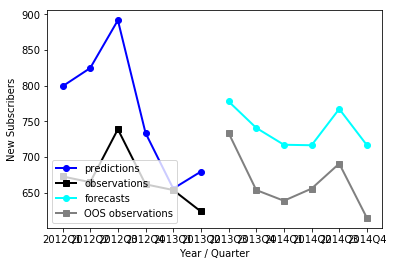

In [30]:
# Visualize outputs
plt.clf()
plt.plot(output_df['predictions'], color = 'blue', lw = 2, marker = 'o')
plt.plot(output_df['observations'], color = 'black', lw = 2, marker = 's')
plt.plot(output_df['forecasts'], color = 'aqua', lw = 2, marker = 'o')
if trainingsize != 100:
    plt.plot(output_df['OOS observations'], color = 'gray', lw = 2, marker = 's')
plt.xticks(output_df.index, output_df['Year / Quarter'])
plt.xlabel('Year / Quarter')
plt.ylabel('New Subscribers')
plt.legend(loc = 'lower left')
plt.show()